# iGEDS

Este notebook, contiene los datos originados por la iniciativa iGEDS donde:


*   Re-escalan todas las métricas a valores entre 1-5 
*   Imputan valores faltantes para algunos paises 
*   Visualiza la distribución de las métricas por país.

## Carga de datos:



In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
! pip install pingouin

     |████████████████████████████████| 215kB 2.7MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.5-cp36-none-any.whl size=213104 sha256=0fac870128415de89db70383c1b450fc255b654b022c96f3feb7d587d3a7d9d5
  Stored in directory: /root/.cache/pip/wheels/99/03/2f/eb0dcf89fefc479f0a574d98c529e331ac90cbaed11236078a
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4962 sha256=687cc0748e9a645b7d945a1974debea0ee9236cac2cf5b7d3eff95e4a31b693a
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7049 sha256=4844eb47cad9f34b08c9b0573a6acf38891d05b2acb7dd57ee452efa1fbfda44
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


Primeras 5 entradas de los datos originales:

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/NunezKant/iGEDS/master/iEcosystems%20v3.csv', decimal=",")
df.head(25)

Pillar  ...      Type
0   1 Foundational Institutions  ...  Positive
1   1 Foundational Institutions  ...  Positive
2   1 Foundational Institutions  ...  Positive
3   1 Foundational Institutions  ...  Positive
4   1 Foundational Institutions  ...  Positive
5   1 Foundational Institutions  ...  Positive
6   1 Foundational Institutions  ...  Positive
7   1 Foundational Institutions  ...  Positive
8   1 Foundational Institutions  ...  Positive
9   1 Foundational Institutions  ...  Positive
10         2.01 I-Human Capital  ...  Positive
11         2.01 I-Human Capital  ...  Positive
12         2.01 I-Human Capital  ...  Positive
13         2.01 I-Human Capital  ...  Positive
14         2.01 I-Human Capital  ...  Positive
15               2.02 I-Funding  ...  Positive
16               2.02 I-Funding  ...  Positive
17               2.02 I-Funding  ...  Positive
18               2.02 I-Funding  ...  Positive
19        2.03 I-Infrastructure  ...  Positive
20        2.03 I-Infrastructure  ...  Positive
21        2.03 I-Infrastructure  ...  Positive
22        2.03 I-Infrastructure  ...  Positive
23                2.04 I-Demand  ...  Positive
24                2.04 I-Demand  ...  Positive

[25 rows x 11 columns]

Proceso de re-escalamiento:

In [5]:
all_columns = df.columns.values.tolist()
metrics = ["Metrics","México","Argentina","Chile","Brasil","España","Uruguay"]
df_metrics = df[metrics]
df_pilars = df[["Pillar","Type"]]
column_names = df["Metrics"].values
df_metrics = df_metrics.T
df_metrics.columns = column_names
df_metrics.drop("Metrics", axis = 0, inplace = True)
for col,val1,val2 in zip(df_metrics.columns, df['Worst performance (1)'],df['Frontier (5)']):
  df_metrics[col] = df_metrics[col].apply(lambda x: (x-val1)/(val2-val1))

df_metrics = np.round((df_metrics*4)+1,2)

El siguiente DataFrame contiene los datos re-escalados del 1-5, sin embargo algunas entradas siguen teniendo valores faltantes, dichos valores se van a inferir con la técnica de **K-vecinos cercanos**.

In [6]:
df_metrics

1.01 Ease of doing business (WB)  ...  5.11 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production)
México                                 3.90  ...                                               1.71                                              
Argentina                              3.36  ...                                               2.03                                              
Chile                                  3.90  ...                                               5.00                                              
Brasil                                 3.36  ...                                               2.18                                              
España                                 4.12  ...                                               1.68                                              
Uruguay                                3.46  ...                                               4.32                                              

[6 rows x 61 columns]

Total de valores faltantes:
* Brasil tiene 2 valores faltantes, por 1 de chile y de argentina

In [7]:
df.isnull().sum()

Pillar                   0
Metrics                  0
México                   0
Argentina                1
Chile                    1
Brasil                   2
España                   0
Uruguay                  3
Worst performance (1)    0
Frontier (5)             0
Type                     0
dtype: int64

Se van a rellenar los valores faltantes con la media de los 3 vecinos más cercanos al país, la distancia entre los países la dictan los valores que tienen en cada métrica.

In [8]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
var = imputer.fit_transform(df_metrics)
df_imputed = pd.DataFrame(var)
df_imputed.columns = column_names
df_imputed.index = df_metrics.index
df_imputed.head(6)

1.01 Ease of doing business (WB)  ...  5.11 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production)
México                                 3.90  ...                                               1.71                                              
Argentina                              3.36  ...                                               2.03                                              
Chile                                  3.90  ...                                               5.00                                              
Brasil                                 3.36  ...                                               2.18                                              
España                                 4.12  ...                                               1.68                                              
Uruguay                                3.46  ...                                               4.32                                              

[6 rows x 61 columns]

Se concatenan los nombres de los pilares y del tipo de relación que tiene la variable, este df servirá para obtener las correlaciones.

In [9]:
df_concat = pd.concat([df_pilars,df_imputed.T.reset_index()], axis = 1).rename(columns={'index':'Metrics'})
df_concat

Pillar      Type  ... España   Uruguay
0   1 Foundational Institutions  Positive  ...   4.12  3.460000
1   1 Foundational Institutions  Positive  ...   4.48  4.580000
2   1 Foundational Institutions  Positive  ...   4.39  3.810000
3   1 Foundational Institutions  Positive  ...   4.17  3.140000
4   1 Foundational Institutions  Positive  ...   3.84  3.250000
..                          ...       ...  ...    ...       ...
56                     5 Impact  Negative  ...   2.57  4.020000
57                     5 Impact  Negative  ...   4.56  4.870000
58                     5 Impact  Negative  ...   4.90  4.643333
59                     5 Impact  Negative  ...   4.82  4.870000
60                     5 Impact  Positive  ...   1.68  4.320000

[61 rows x 9 columns]

In [10]:
df_concat.drop('Type',axis=1,inplace = True)
df_concat

Pillar  ...   Uruguay
0   1 Foundational Institutions  ...  3.460000
1   1 Foundational Institutions  ...  4.580000
2   1 Foundational Institutions  ...  3.810000
3   1 Foundational Institutions  ...  3.140000
4   1 Foundational Institutions  ...  3.250000
..                          ...  ...       ...
56                     5 Impact  ...  4.020000
57                     5 Impact  ...  4.870000
58                     5 Impact  ...  4.643333
59                     5 Impact  ...  4.870000
60                     5 Impact  ...  4.320000

[61 rows x 8 columns]

Por último se obtiene el **tidy** dataframe, el cuál contiene:
una carácteristica por columna y una observación por fila.

In [11]:
final_df = pd.melt(df_concat,id_vars=['Pillar','Metrics'],value_vars=["México","Argentina","Chile","Brasil","España",'Uruguay'],value_name="Value",var_name="Country")
final_df

Pillar  ...     Value
0    1 Foundational Institutions  ...  3.900000
1    1 Foundational Institutions  ...  4.440000
2    1 Foundational Institutions  ...  3.630000
3    1 Foundational Institutions  ...  3.810000
4    1 Foundational Institutions  ...  3.680000
..                           ...  ...       ...
361                     5 Impact  ...  4.020000
362                     5 Impact  ...  4.870000
363                     5 Impact  ...  4.643333
364                     5 Impact  ...  4.870000
365                     5 Impact  ...  4.320000

[366 rows x 4 columns]

Ya tenemos los datos limpios, re-escalados, sin valores faltantes y con todas las métricas en 'positivo' ahora podemos empezar a hacer visualizaciones y obtener información del set de datos.

vamos a obtener la media por pilar de cada país para obtener la matriz de correlación.

In [12]:
corr =df_concat.groupby('Pillar').mean().T.corr()

Nos interesa como se relacionan las métricas con las variables de salida:


*   4 Comparative Advantage
*   5 Impact



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


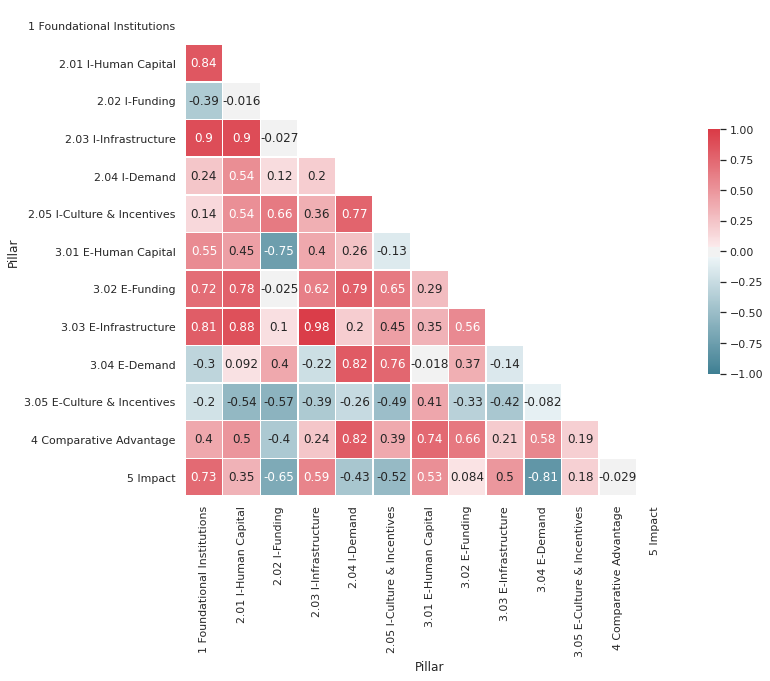

In [13]:
import seaborn as sns
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
df_means = df_concat.groupby('Pillar').mean().T

In [15]:
import pingouin as pg

In [16]:
df_means.rcorr()

Pillar                      1 Foundational Institutions  ... 5 Impact
Pillar                                                   ...         
1 Foundational Institutions                           -  ...         
2.01 I-Human Capital                               0.84  ...         
2.02 I-Funding                                   -0.388  ...         
2.03 I-Infrastructure                             0.896  ...         
2.04 I-Demand                                     0.241  ...         
2.05 I-Culture & Incentives                        0.14  ...         
3.01 E-Human Capital                              0.555  ...         
3.02 E-Funding                                    0.719  ...         
3.03 E-Infrastructure                             0.806  ...         
3.04 E-Demand                                    -0.303  ...         
3.05 E-Culture & Incentives                      -0.202  ...         
4 Comparative Advantage                           0.399  ...         
5 Impact                                          0.735  ...        -

[13 rows x 13 columns]

In [17]:
#@title significance cheking { display-mode: "form" }
def check_corr_significance(df,a,b):
  import scipy.stats as stats
  r = stats.pearsonr(df[a], df[b])
  print(f'Correlation between:  ' + a + '   and   ' + b)
  print('**********************************************')
  print(f'Pearson Correlation: {r[0]}, p-value: {r[1]}')
  if r[1] < 0.05:
    print('*Statistically significant*')
    print('**********************************************')
    print('')

    sns.lmplot(x=b, y=a, data=df)
    return True
  else:
    print('Not significant')
    print('**********************************************')
    print('')

    sns.lmplot(x=b, y=a, data=df)
    return False
  

Correlation between:  4 Comparative Advantage   and   2.04 I-Demand
**********************************************
Pearson Correlation: 0.8184860452505838, p-value: 0.04643077486137577
*Statistically significant*
**********************************************



True

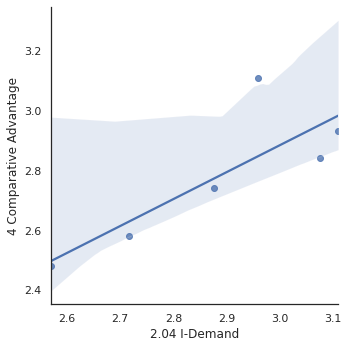

In [18]:
check_corr_significance(df_means,'4 Comparative Advantage','2.04 I-Demand')

In [19]:
#@title Función de spider plot
def make_spider_comparison(df,country_name1,country_name2):
  from math import pi
  categories=list(df)
  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  fig = plt.figure(figsize=(8, 8))
  # Initialise the spider plot
  ax = plt.subplot(111, polar=True)
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories )
  # Draw ylabels
  ax.set_rlabel_position(0)
  plt.yticks([1,2,3,4,5], ["1","2","3","4",""], color="grey", size=13)
  plt.ylim(0,5)
  
  
  # ------- PART 2: Add plots
  
  # Plot each individual = each line of the data
  # I don't do a loop, because plotting more than 3 groups makes the chart unreadable
  
  # Ind1
  values=df.loc[country_name1].values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=1, linestyle='solid', label=country_name1)
  ax.fill(angles, values, 'b', alpha=0.1)
  
  # Ind2
  values=df.loc[country_name2].values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=1, linestyle='solid', label=country_name2)
  ax.fill(angles, values, 'r', alpha=0.1)
  
  # Add legend
  plt.legend( bbox_to_anchor=(0.05, 0.25))
  plt.tight_layout()

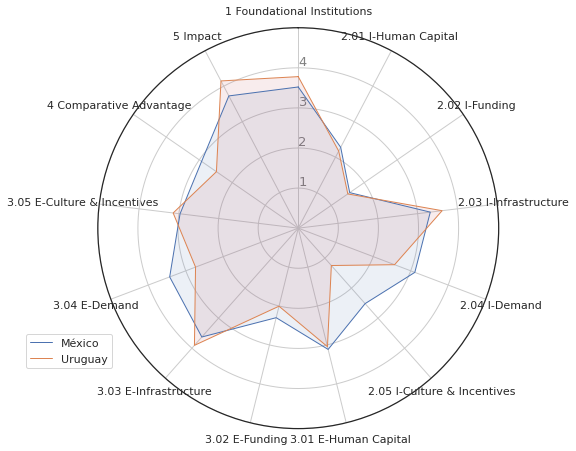

In [20]:
make_spider_comparison(df_means,'México','Uruguay')

In [25]:
#Graph_df = pd.read_csv('https://raw.githubusercontent.com/NunezKant/iGEDS/master/Graph_DF.csv')
Graph_df = pd.read_csv('https://raw.githubusercontent.com/OlgaMMC/iGED/master/Tidy_DataFrame.csv')
Graph_df

Ciudad       País  ...  Central Point Dominance  Spectral radius
0               CABA  Argentina  ...                    0.251            1.868
1               CDMX     México  ...                    0.202            1.910
2  Santiago de Chile      Chile  ...                    0.525            1.890
3         Montevideo    Uruguay  ...                    0.179            1.778
4             Madrid     España  ...                    0.184            1.920
5          Sao Paulo     Brasil  ...                    0.237            1.983

[6 rows x 18 columns]

In [26]:
df_means.columns.name = ''
Graph_df.drop('Ciudad', axis = 1, inplace=True)
Graph_df.set_index('País',inplace=True)
Graph_df.index.name = ''

In [27]:
df_graph_ieco = pd.concat([df_means,Graph_df], axis = 1)
df_graph_ieco

1 Foundational Institutions  ...  Spectral radius
México                           3.522  ...            1.910
Argentina                        3.169  ...            1.868
Chile                            3.913  ...            1.890
Brasil                           3.177  ...            1.983
España                           3.929  ...            1.920
Uruguay                          3.780  ...            1.778

[6 rows x 29 columns]

In [28]:
ieco_global_corr_df=df_graph_ieco.corr()
pd.set_option("display.max_rows", None, "display.max_columns", None)
ieco_global_corr_df


1 Foundational Institutions  \
1 Foundational Institutions                     1.000000   
2.01 I-Human Capital                            0.840274   
2.02 I-Funding                                 -0.387851   
2.03 I-Infrastructure                           0.896183   
2.04 I-Demand                                   0.241385   
2.05 I-Culture & Incentives                     0.139546   
3.01 E-Human Capital                            0.554805   
3.02 E-Funding                                  0.719206   
3.03 E-Infrastructure                           0.805614   
3.04 E-Demand                                  -0.303465   
3.05 E-Culture & Incentives                    -0.202260   
4 Comparative Advantage                         0.398735   
5 Impact                                        0.734565   
avg strength                                    0.282043   
weight                                          0.308403   
Degree                                          0.270243   
Weighted Degree                                 0.310834   
Eccentricidad                                  -0.248765   
Clustering                                      0.119891   
Diámetro                                       -0.101749   
Radio                                           0.161879   
Camino más corto promedio                      -0.455479   
Transitividad                                   0.256974   
Eficiencia Global                               0.434262   
Small Worldness                                 0.057238   
Rich Club Coefficient                           0.526316   
Core Ratio                                      0.073141   
Central Point Dominance                         0.269750   
Spectral radius                                -0.351757   

                             2.01 I-Human Capital  2.02 I-Funding  \
1 Foundational Institutions              0.840274       -0.387851   
2.01 I-Human Capital                     1.000000       -0.016269   
2.02 I-Funding                          -0.016269        1.000000   
2.03 I-Infrastructure                    0.903394       -0.027129   
2.04 I-Demand                            0.543974        0.118169   
2.05 I-Culture & Incentives              0.536930        0.655465   
3.01 E-Human Capital                     0.450810       -0.747778   
3.02 E-Funding                           0.784386       -0.024527   
3.03 E-Infrastructure                    0.881426        0.104712   
3.04 E-Demand                            0.092240        0.403245   
3.05 E-Culture & Incentives             -0.537658       -0.570975   
4 Comparative Advantage                  0.502177       -0.400578   
5 Impact                                 0.346690       -0.654334   
avg strength                             0.534109        0.223853   
weight                                  -0.130836       -0.311220   
Degree                                  -0.141129       -0.270942   
Weighted Degree                         -0.125112       -0.308998   
Eccentricidad                            0.006499        0.599906   
Clustering                              -0.220874       -0.154678   
Diámetro                                 0.169760        0.738507   
Radio                                    0.490421        0.700507   
Camino más corto promedio               -0.199446        0.631247   
Transitividad                           -0.155289       -0.271756   
Eficiencia Global                        0.101512       -0.628286   
Small Worldness                         -0.104863        0.373340   
Rich Club Coefficient                    0.089858       -0.360532   
Core Ratio                              -0.221589       -0.117499   
Central Point Dominance                  0.169749       -0.729078   
Spectral radius                         -0.024491        0.433691   

                             2.03 I-Infrastructure  2.04 I-Demand  \
1 Foundational Institutions               0.896183       0.241385   
2.01 I-Human Capita

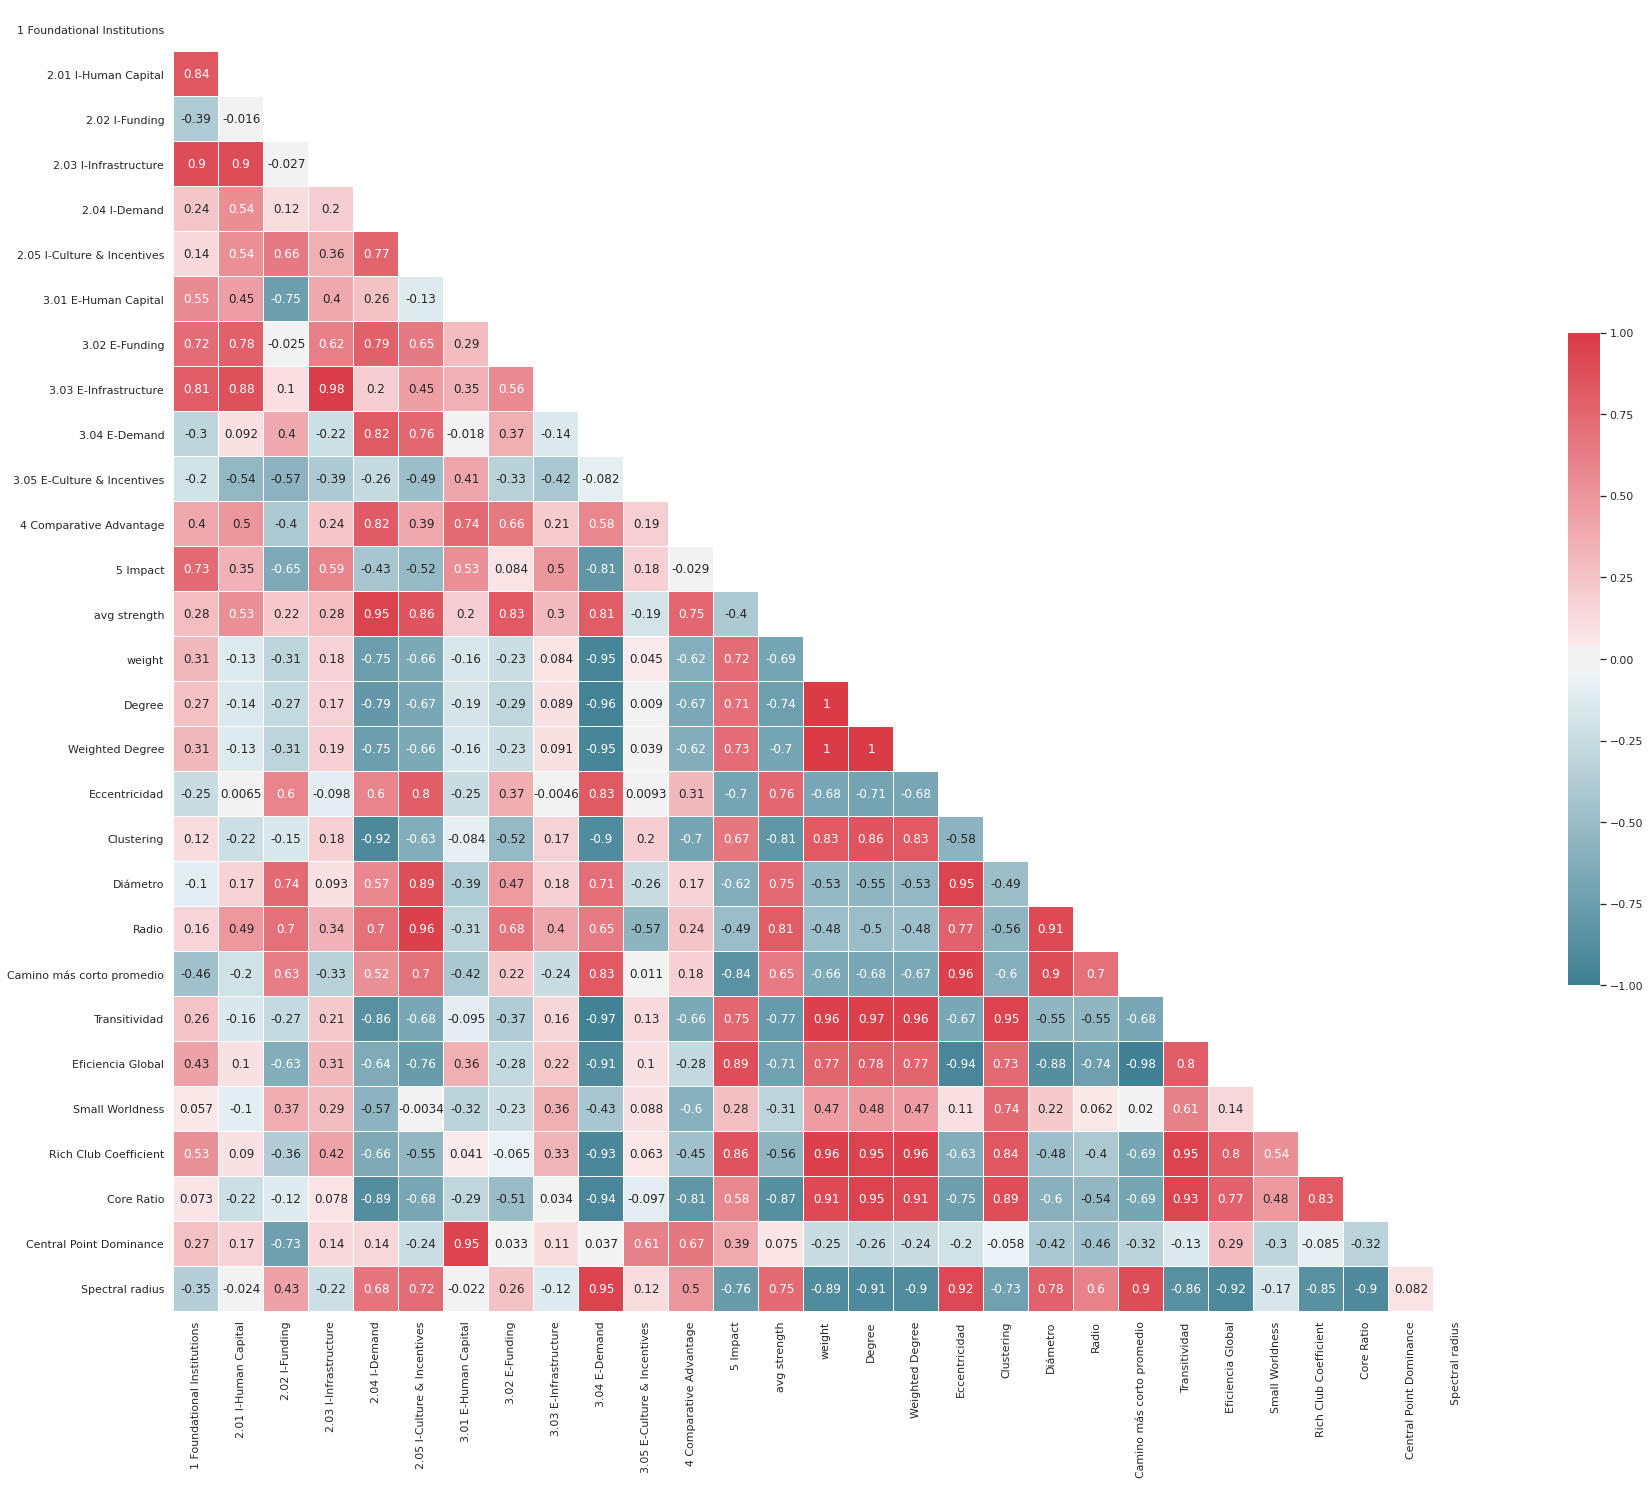

In [29]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(ieco_global_corr_df, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(32, 24))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(ieco_global_corr_df, mask=mask, cmap=cmap, annot=True, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlation between:  1 Foundational Institutions   and   avg strength
**********************************************
Pearson Correlation: 0.282043373730671, p-value: 0.5881529980786528
Not significant
**********************************************

Correlation between:  1 Foundational Institutions   and   weight
**********************************************
Pearson Correlation: 0.3084033697998984, p-value: 0.5520614744127386
Not significant
**********************************************

Correlation between:  1 Foundational Institutions   and   Degree
**********************************************
Pearson Correlation: 0.2702432921879119, p-value: 0.6045031896984716
Not significant
**********************************************

Correlation between:  1 Foundational Institutions   and   Weighted Degree
**********************************************
Pearson Correlation: 0.31083391289738205, p-value: 0.5487651628540254
Not significant
**********************************************

Corre

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Clustering
**********************************************
Pearson Correlation: -0.2208739270126756, p-value: 0.6740768089528169
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Diámetro
**********************************************
Pearson Correlation: 0.1697601052855031, p-value: 0.7478059573040848
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Radio
**********************************************
Pearson Correlation: 0.4904207256471201, p-value: 0.3233450660107681
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Camino más corto promedio
**********************************************
Pearson Correlation: -0.19944574164586137, p-value: 0.7047982241055217
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Transitividad
**********************************************
Pearson Correlation: -0.15528882595757676, p-value: 0.7689391265363789
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Eficiencia Global
**********************************************
Pearson Correlation: 0.10151181487438593, p-value: 0.8482552994768594
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Small Worldness
**********************************************
Pearson Correlation: -0.10486301252289333, p-value: 0.8432820312395494
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Rich Club Coefficient
**********************************************
Pearson Correlation: 0.08985763603213481, p-value: 0.865576318964258
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Core Ratio
**********************************************
Pearson Correlation: -0.2215894779291998, p-value: 0.6730560149369494
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.16974944740039283, p-value: 0.7478214834443876
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.01 I-Human Capital   and   Spectral radius
**********************************************
Pearson Correlation: -0.02449078177350897, p-value: 0.9632711721054983
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   avg strength
**********************************************
Pearson Correlation: 0.22385277929097466, p-value: 0.6698294699249414
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   weight
**********************************************
Pearson Correlation: -0.31121989238712966, p-value: 0.5482422017985019
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Degree
**********************************************
Pearson Correlation: -0.2709418576975854, p-value: 0.6035320652844606
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Weighted Degree
**********************************************
Pearson Correlation: -0.3089983196024768, p-value: 0.5512540944285398
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Eccentricidad
**********************************************
Pearson Correlation: 0.599905990665631, p-value: 0.2080902569145583
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Clustering
**********************************************
Pearson Correlation: -0.15467757274572846, p-value: 0.7698339830630171
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Diámetro
**********************************************
Pearson Correlation: 0.7385065695777545, p-value: 0.09362791589032411
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Radio
**********************************************
Pearson Correlation: 0.7005067480885, p-value: 0.12111260741066879
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Camino más corto promedio
**********************************************
Pearson Correlation: 0.6312466686277385, p-value: 0.17889717089731247
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Transitividad
**********************************************
Pearson Correlation: -0.27175552656129864, p-value: 0.6024014278514558
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Eficiencia Global
**********************************************
Pearson Correlation: -0.6282860173040314, p-value: 0.1815768280894576
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Small Worldness
**********************************************
Pearson Correlation: 0.3733395266914752, p-value: 0.46600918999419505
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Rich Club Coefficient
**********************************************
Pearson Correlation: -0.3605317877702118, p-value: 0.4826338506734514
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Core Ratio
**********************************************
Pearson Correlation: -0.11749923272862604, p-value: 0.8245622522049542
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Central Point Dominance
**********************************************
Pearson Correlation: -0.7290778219701586, p-value: 0.10015555484598163
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.02 I-Funding   and   Spectral radius
**********************************************
Pearson Correlation: 0.43369113081181476, p-value: 0.39024935182584425
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   avg strength
**********************************************
Pearson Correlation: 0.28445976842715354, p-value: 0.5848192140821199
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   weight
**********************************************
Pearson Correlation: 0.17964652140929419, p-value: 0.7334290725401882
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Degree
**********************************************
Pearson Correlation: 0.17393096066878547, p-value: 0.7417344368885075
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Weighted Degree
**********************************************
Pearson Correlation: 0.1859603278388917, p-value: 0.7242748779336152
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Eccentricidad
**********************************************
Pearson Correlation: -0.09840958897042251, p-value: 0.8528621377786104
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Clustering
**********************************************
Pearson Correlation: 0.18363892075712815, p-value: 0.7276380697768878
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Diámetro
**********************************************
Pearson Correlation: 0.09305885520343214, p-value: 0.8608146597361543
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Radio
**********************************************
Pearson Correlation: 0.3447356504512039, p-value: 0.5033811766696434
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Camino más corto promedio
**********************************************
Pearson Correlation: -0.33378627331255784, p-value: 0.5179147011699929
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Transitividad
**********************************************
Pearson Correlation: 0.21494720981345108, p-value: 0.6825447133389343
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Eficiencia Global
**********************************************
Pearson Correlation: 0.3117475598246614, p-value: 0.5475274937741098
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Small Worldness
**********************************************
Pearson Correlation: 0.2927716084160143, p-value: 0.5733900780118949
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Rich Club Coefficient
**********************************************
Pearson Correlation: 0.42483476082872557, p-value: 0.4010859191729783
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Core Ratio
**********************************************
Pearson Correlation: 0.07815376958704852, p-value: 0.8830080276889716
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.13618035425896294, p-value: 0.796992206998692
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.03 I-Infrastructure   and   Spectral radius
**********************************************
Pearson Correlation: -0.22454069543098457, p-value: 0.668849462063598
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   avg strength
**********************************************
Pearson Correlation: 0.9521163141014182, p-value: 0.0033843760710865188
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   weight
**********************************************
Pearson Correlation: -0.7513026741395321, p-value: 0.08508453028112797
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Degree
**********************************************
Pearson Correlation: -0.7930354359599854, p-value: 0.05981890185570923
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Weighted Degree
**********************************************
Pearson Correlation: -0.7540324234088823, p-value: 0.08330954791577455
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Eccentricidad
**********************************************
Pearson Correlation: 0.599406547934242, p-value: 0.2085700308454441
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Clustering
**********************************************
Pearson Correlation: -0.9174944429171862, p-value: 0.00992993587365419
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Diámetro
**********************************************
Pearson Correlation: 0.5729735439932807, p-value: 0.23459291370030597
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Radio
**********************************************
Pearson Correlation: 0.6996691390452744, p-value: 0.12175322355467552
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Camino más corto promedio
**********************************************
Pearson Correlation: 0.5245724697849072, p-value: 0.2853162447011561
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Transitividad
**********************************************
Pearson Correlation: -0.859276309400167, p-value: 0.028311348968014967
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Eficiencia Global
**********************************************
Pearson Correlation: -0.6438384249216684, p-value: 0.1676868633317426
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Small Worldness
**********************************************
Pearson Correlation: -0.5720319885558817, p-value: 0.23554234125965895
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Rich Club Coefficient
**********************************************
Pearson Correlation: -0.6554758638583902, p-value: 0.15759835048766183
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Core Ratio
**********************************************
Pearson Correlation: -0.8870737503323284, p-value: 0.018408469951269373
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.14102851437630193, p-value: 0.7898596894489958
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.04 I-Demand   and   Spectral radius
**********************************************
Pearson Correlation: 0.6808168137337806, p-value: 0.13655800220593137
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   avg strength
**********************************************
Pearson Correlation: 0.8576669176387266, p-value: 0.02894631744307371
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   weight
**********************************************
Pearson Correlation: -0.6628819948350273, p-value: 0.15131633797672486
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Degree
**********************************************
Pearson Correlation: -0.6723173531372335, p-value: 0.14347126322753506
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Weighted Degree
**********************************************
Pearson Correlation: -0.6623942917180801, p-value: 0.151726674800774
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Eccentricidad
**********************************************
Pearson Correlation: 0.8042285278880069, p-value: 0.05373808928218256
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Clustering
**********************************************
Pearson Correlation: -0.6250677683665501, p-value: 0.18450837228312295
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Diámetro
**********************************************
Pearson Correlation: 0.8885028029536859, p-value: 0.017954391755494337
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Radio
**********************************************
Pearson Correlation: 0.9596725168103402, p-value: 0.0024066664386883847
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Camino más corto promedio
**********************************************
Pearson Correlation: 0.6972660941138702, p-value: 0.12359927573941697
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Transitividad
**********************************************
Pearson Correlation: -0.6761642120864156, p-value: 0.14032415868932127
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Eficiencia Global
**********************************************
Pearson Correlation: -0.7580202266991896, p-value: 0.08074684871617822
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Small Worldness
**********************************************
Pearson Correlation: -0.003378202341376535, p-value: 0.9949327157643817
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Rich Club Coefficient
**********************************************
Pearson Correlation: -0.5467839624855224, p-value: 0.2615607955082173
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Core Ratio
**********************************************
Pearson Correlation: -0.682121493427812, p-value: 0.1355098232230031
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Central Point Dominance
**********************************************
Pearson Correlation: -0.23864268184685908, p-value: 0.6488313669235025
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  2.05 I-Culture & Incentives   and   Spectral radius
**********************************************
Pearson Correlation: 0.7243085128542827, p-value: 0.1035316186497947
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   avg strength
**********************************************
Pearson Correlation: 0.1956065421099846, p-value: 0.7103323277009919
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   weight
**********************************************
Pearson Correlation: -0.1620892391484493, p-value: 0.7589954202011603
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Degree
**********************************************
Pearson Correlation: -0.18637572095473648, p-value: 0.7236733836430197
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Weighted Degree
**********************************************
Pearson Correlation: -0.1596171728101401, p-value: 0.762607575366244
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Eccentricidad
**********************************************
Pearson Correlation: -0.249371699176345, p-value: 0.633696195944972
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Clustering
**********************************************
Pearson Correlation: -0.08414611393181937, p-value: 0.8740787302636944
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Diámetro
**********************************************
Pearson Correlation: -0.38922994349848156, p-value: 0.44563924303054353
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Radio
**********************************************
Pearson Correlation: -0.3121572419905745, p-value: 0.5469727724338983
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Camino más corto promedio
**********************************************
Pearson Correlation: -0.41508639403641395, p-value: 0.41312941991137964
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Transitividad
**********************************************
Pearson Correlation: -0.09466716798538724, p-value: 0.8584234455758304
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Eficiencia Global
**********************************************
Pearson Correlation: 0.36428510652056945, p-value: 0.47774331982306495
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Small Worldness
**********************************************
Pearson Correlation: -0.31895808169272094, p-value: 0.537787359328375
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Rich Club Coefficient
**********************************************
Pearson Correlation: 0.04098080001481122, p-value: 0.9385632120876882
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Core Ratio
**********************************************
Pearson Correlation: -0.2912014484382057, p-value: 0.5755445188433855
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.9458097209373085, p-value: 0.004325312300577863
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.01 E-Human Capital   and   Spectral radius
**********************************************
Pearson Correlation: -0.022217063972385737, p-value: 0.9666798871898322
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   avg strength
**********************************************
Pearson Correlation: 0.83396874419741, p-value: 0.03906112668446374
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   weight
**********************************************
Pearson Correlation: -0.22849284567472233, p-value: 0.6632254207528298
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Degree
**********************************************
Pearson Correlation: -0.2905318601932837, p-value: 0.5764639269994226
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Weighted Degree
**********************************************
Pearson Correlation: -0.23125819218761495, p-value: 0.6592965964159694
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Eccentricidad
**********************************************
Pearson Correlation: 0.3680281300534823, p-value: 0.4728815355831295
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Clustering
**********************************************
Pearson Correlation: -0.5215327324990132, p-value: 0.2886284117832329
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Diámetro
**********************************************
Pearson Correlation: 0.4744472233654329, p-value: 0.3417282397380661
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Radio
**********************************************
Pearson Correlation: 0.6846010681910782, p-value: 0.1335273405376957
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Camino más corto promedio
**********************************************
Pearson Correlation: 0.2166155776979121, p-value: 0.6801586849346071
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Transitividad
**********************************************
Pearson Correlation: -0.37007145036229977, p-value: 0.47023399962199164
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Eficiencia Global
**********************************************
Pearson Correlation: -0.27632781761407044, p-value: 0.5960580638386196
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Small Worldness
**********************************************
Pearson Correlation: -0.2292493515778995, p-value: 0.6621501028675756
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Rich Club Coefficient
**********************************************
Pearson Correlation: -0.064698716716201, p-value: 0.9030873368794461
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Core Ratio
**********************************************
Pearson Correlation: -0.5066783292722379, p-value: 0.30502047855714987
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.03327852305598296, p-value: 0.9501006427342079
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.02 E-Funding   and   Spectral radius
**********************************************
Pearson Correlation: 0.26296666100425525, p-value: 0.6146422733945859
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   avg strength
**********************************************
Pearson Correlation: 0.29996377858108564, p-value: 0.5635494428271905
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   weight
**********************************************
Pearson Correlation: 0.08356973235360741, p-value: 0.8749372228034028
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Degree
**********************************************
Pearson Correlation: 0.08901438301033232, p-value: 0.8668310809038577
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Weighted Degree
**********************************************
Pearson Correlation: 0.09088845631297005, p-value: 0.8640427171882747
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Eccentricidad
**********************************************
Pearson Correlation: -0.004642827135460173, p-value: 0.9930358093368381
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Clustering
**********************************************
Pearson Correlation: 0.17484174551220044, p-value: 0.7404098059883611
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Diámetro
**********************************************
Pearson Correlation: 0.18086397317030772, p-value: 0.731662231204474
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Radio
**********************************************
Pearson Correlation: 0.4039439620616582, p-value: 0.4270399713781999
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Camino más corto promedio
**********************************************
Pearson Correlation: -0.24425077889442548, p-value: 0.6409096422423951
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Transitividad
**********************************************
Pearson Correlation: 0.15601037537404056, p-value: 0.7678830237067835
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Eficiencia Global
**********************************************
Pearson Correlation: 0.22327134982949493, p-value: 0.670658024328733
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Small Worldness
**********************************************
Pearson Correlation: 0.36003708576835725, p-value: 0.4832795815635495
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Rich Club Coefficient
**********************************************
Pearson Correlation: 0.3339432748936212, p-value: 0.5177054492326127
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Core Ratio
**********************************************
Pearson Correlation: 0.03381224946691031, p-value: 0.9493009540346645
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.11345652566385861, p-value: 0.8305454394425462
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.03 E-Infrastructure   and   Spectral radius
**********************************************
Pearson Correlation: -0.12338452570194541, p-value: 0.8158623984896999
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   avg strength
**********************************************
Pearson Correlation: 0.8088411132847813, p-value: 0.05131994270122123
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   weight
**********************************************
Pearson Correlation: -0.9463687283104187, p-value: 0.004237339784452628
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Degree
**********************************************
Pearson Correlation: -0.9626246701606463, p-value: 0.002069267836215682
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Weighted Degree
**********************************************
Pearson Correlation: -0.9496417749365054, p-value: 0.003740073255955904
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Eccentricidad
**********************************************
Pearson Correlation: 0.8281029252267336, p-value: 0.04178324715066623
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Clustering
**********************************************
Pearson Correlation: -0.8980342032527658, p-value: 0.01506546515644111
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Diámetro
**********************************************
Pearson Correlation: 0.7132895141074862, p-value: 0.1115201369906655
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Radio
**********************************************
Pearson Correlation: 0.6466758978930478, p-value: 0.1652027584985039
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Camino más corto promedio
**********************************************
Pearson Correlation: 0.8298911750732905, p-value: 0.04094429789577112
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Transitividad
**********************************************
Pearson Correlation: -0.9712565321782046, p-value: 0.0012274066747367239
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Eficiencia Global
**********************************************
Pearson Correlation: -0.912144555017792, p-value: 0.011238809213837436
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Small Worldness
**********************************************
Pearson Correlation: -0.4257077535934603, p-value: 0.4000132586097074
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Rich Club Coefficient
**********************************************
Pearson Correlation: -0.9299910736282685, p-value: 0.007180309040384791
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Core Ratio
**********************************************
Pearson Correlation: -0.9413661463985242, p-value: 0.005056103675610325
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.036675421731366065, p-value: 0.9450115332113623
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.04 E-Demand   and   Spectral radius
**********************************************
Pearson Correlation: 0.9475504861581765, p-value: 0.004054284218917897
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   avg strength
**********************************************
Pearson Correlation: -0.187665584413653, p-value: 0.7218062615212223
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   weight
**********************************************
Pearson Correlation: 0.04484544873687535, p-value: 0.9327769215556907
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Degree
**********************************************
Pearson Correlation: 0.00897941525004043, p-value: 0.9865312391296084
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Weighted Degree
**********************************************
Pearson Correlation: 0.03877340578112973, p-value: 0.9418690368514566
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Eccentricidad
**********************************************
Pearson Correlation: 0.009273161065071228, p-value: 0.9860906571089828
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Clustering
**********************************************
Pearson Correlation: 0.20274114059868437, p-value: 0.7000550219916911
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Diámetro
**********************************************
Pearson Correlation: -0.2560193069393741, p-value: 0.6243615456834497
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Radio
**********************************************
Pearson Correlation: -0.5701718030549432, p-value: 0.23742254887537495
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Camino más corto promedio
**********************************************
Pearson Correlation: 0.010536795190823216, p-value: 0.9841953921326186
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Transitividad
**********************************************
Pearson Correlation: 0.12946873967141054, p-value: 0.8068819780049035
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Eficiencia Global
**********************************************
Pearson Correlation: 0.10151353355841385, p-value: 0.8482527480169193
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Small Worldness
**********************************************
Pearson Correlation: 0.08768438671717, p-value: 0.8688105028933825
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Rich Club Coefficient
**********************************************
Pearson Correlation: 0.06283689454001379, p-value: 0.9058687131534742
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Core Ratio
**********************************************
Pearson Correlation: -0.0973003593032885, p-value: 0.8545100498060287
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.6122809964213417, p-value: 0.19634691014888525
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  3.05 E-Culture & Incentives   and   Spectral radius
**********************************************
Pearson Correlation: 0.11912422106461328, p-value: 0.8221588893001932
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   avg strength
**********************************************
Pearson Correlation: 0.7546943496725864, p-value: 0.08288167628557114
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   weight
**********************************************
Pearson Correlation: -0.6154286630397586, p-value: 0.1934045591082865
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Degree
**********************************************
Pearson Correlation: -0.66628782957837, p-value: 0.14846398921208334
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Weighted Degree
**********************************************
Pearson Correlation: -0.6177231976016753, p-value: 0.1912712143944555
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Eccentricidad
**********************************************
Pearson Correlation: 0.3056189425428559, p-value: 0.5558444397629613
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Clustering
**********************************************
Pearson Correlation: -0.6951563696558851, p-value: 0.12522995418829164
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Diámetro
**********************************************
Pearson Correlation: 0.16737868620527577, p-value: 0.7512765799111195
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Radio
**********************************************
Pearson Correlation: 0.24398233920811016, p-value: 0.6412883061226298
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Camino más corto promedio
**********************************************
Pearson Correlation: 0.1807421539614863, p-value: 0.7318389866586611
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Transitividad
**********************************************
Pearson Correlation: -0.6588645994623239, p-value: 0.1547105056063918
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Eficiencia Global
**********************************************
Pearson Correlation: -0.27547069929515017, p-value: 0.5972458749533155
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Small Worldness
**********************************************
Pearson Correlation: -0.5958244139238369, p-value: 0.21202421819853273
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Rich Club Coefficient
**********************************************
Pearson Correlation: -0.45422066016571144, p-value: 0.3655255973013873
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Core Ratio
**********************************************
Pearson Correlation: -0.8092797354552281, p-value: 0.051092678597523346
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.6665465578459969, p-value: 0.14824825325730204
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  4 Comparative Advantage   and   Spectral radius
**********************************************
Pearson Correlation: 0.4994654381767627, p-value: 0.3131015962920219
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   avg strength
**********************************************
Pearson Correlation: -0.39574180717690666, p-value: 0.4373761636755538
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   weight
**********************************************
Pearson Correlation: 0.7219779787302387, p-value: 0.10519933742644325
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Degree
**********************************************
Pearson Correlation: 0.7089407238278236, p-value: 0.11474463698668406
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Weighted Degree
**********************************************
Pearson Correlation: 0.7254106445150381, p-value: 0.10274704668083949
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Eccentricidad
**********************************************
Pearson Correlation: -0.7011349839363727, p-value: 0.12063309061767412
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Clustering
**********************************************
Pearson Correlation: 0.6709264550874556, p-value: 0.14461650891017602
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Diámetro
**********************************************
Pearson Correlation: -0.6248091498278942, p-value: 0.18474479562926616
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Radio
**********************************************
Pearson Correlation: -0.4925677237551017, p-value: 0.3209025345483949
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Camino más corto promedio
**********************************************
Pearson Correlation: -0.8363679868760034, p-value: 0.03797249435403064
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Transitividad
**********************************************
Pearson Correlation: 0.754530310477201, p-value: 0.08298761941588023
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Eficiencia Global
**********************************************
Pearson Correlation: 0.8863871378854795, p-value: 0.018628572922978447
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Small Worldness
**********************************************
Pearson Correlation: 0.2779670072096816, p-value: 0.5937881409171638
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Rich Club Coefficient
**********************************************
Pearson Correlation: 0.8614038002489668, p-value: 0.02748221915108597
*Statistically significant*
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Core Ratio
**********************************************
Pearson Correlation: 0.579523691371604, p-value: 0.2280303149314966
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Central Point Dominance
**********************************************
Pearson Correlation: 0.38845320835561037, p-value: 0.44662818475268645
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Correlation between:  5 Impact   and   Spectral radius
**********************************************
Pearson Correlation: -0.7608863556623298, p-value: 0.0789273010145706
Not significant
**********************************************



/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


[('2.04 I-Demand', 'avg strength'),
 ('2.04 I-Demand', 'Clustering'),
 ('2.04 I-Demand', 'Transitividad'),
 ('2.04 I-Demand', 'Core Ratio'),
 ('2.05 I-Culture & Incentives', 'avg strength'),
 ('2.05 I-Culture & Incentives', 'Diámetro'),
 ('2.05 I-Culture & Incentives', 'Radio'),
 ('3.01 E-Human Capital', 'Central Point Dominance'),
 ('3.02 E-Funding', 'avg strength'),
 ('3.04 E-Demand', 'weight'),
 ('3.04 E-Demand', 'Degree'),
 ('3.04 E-Demand', 'Weighted Degree'),
 ('3.04 E-Demand', 'Eccentricidad'),
 ('3.04 E-Demand', 'Clustering'),
 ('3.04 E-Demand', 'Camino más corto promedio'),
 ('3.04 E-Demand', 'Transitividad'),
 ('3.04 E-Demand', 'Eficiencia Global'),
 ('3.04 E-Demand', 'Rich Club Coefficient'),
 ('3.04 E-Demand', 'Core Ratio'),
 ('3.04 E-Demand', 'Spectral radius'),
 ('5 Impact', 'Camino más corto promedio'),
 ('5 Impact', 'Eficiencia Global'),
 ('5 Impact', 'Rich Club Coefficient')]

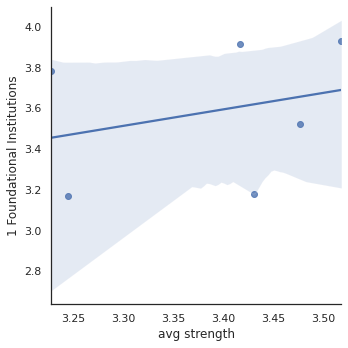

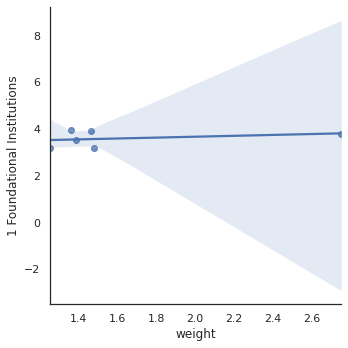

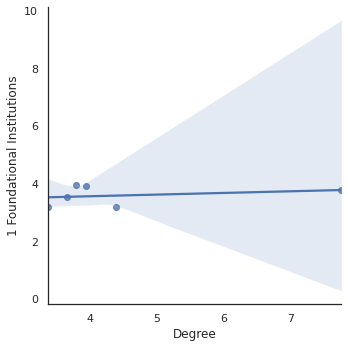

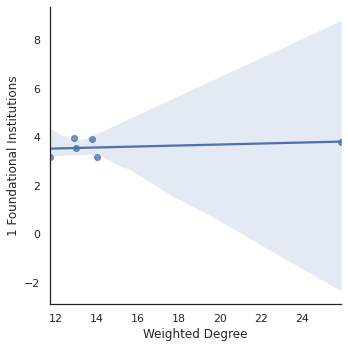

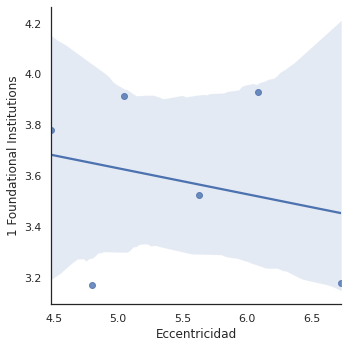

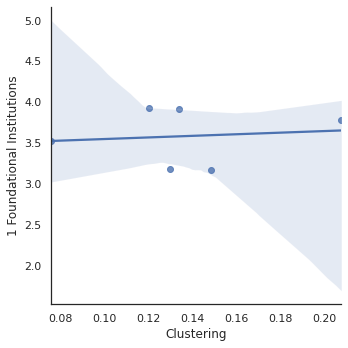

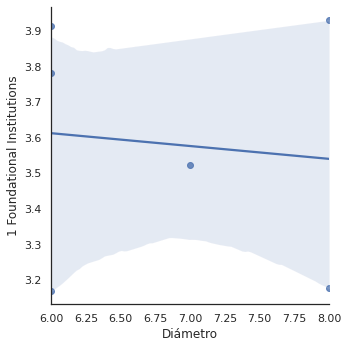

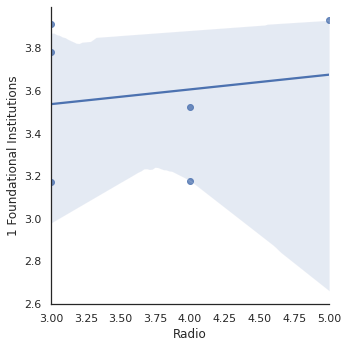

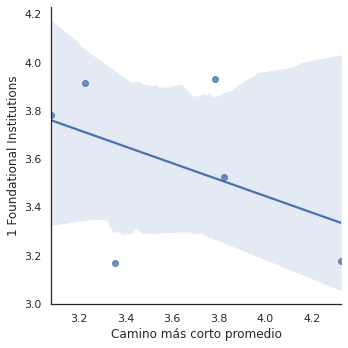

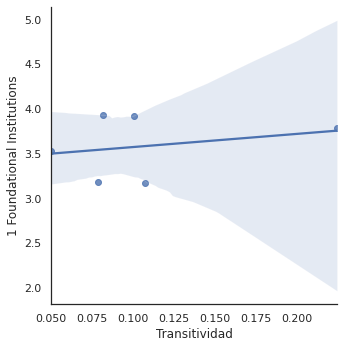

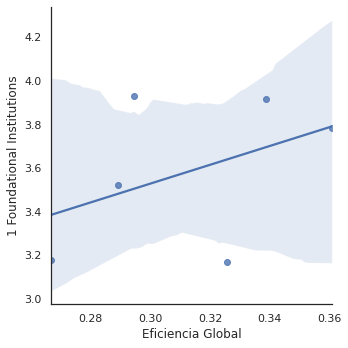

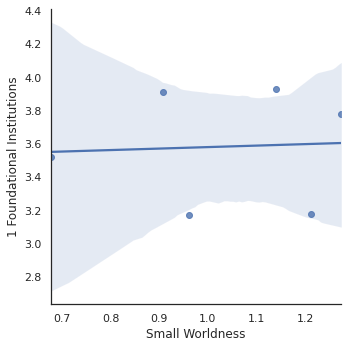

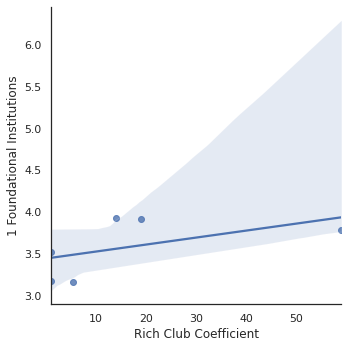

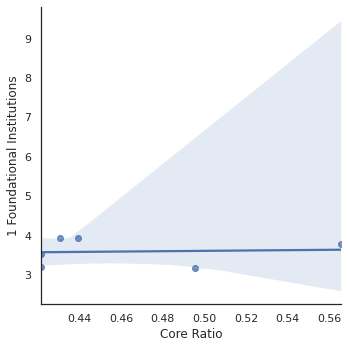

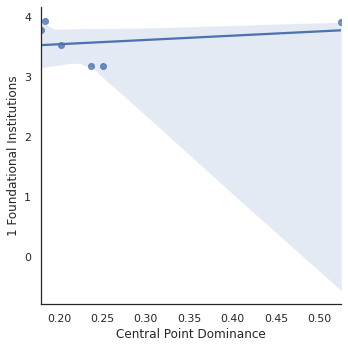

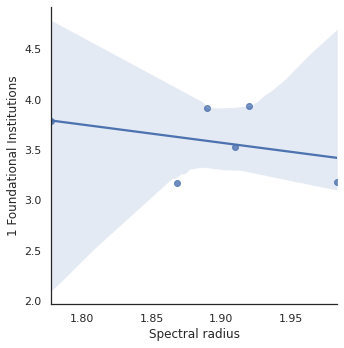

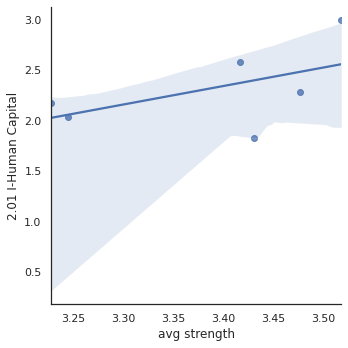

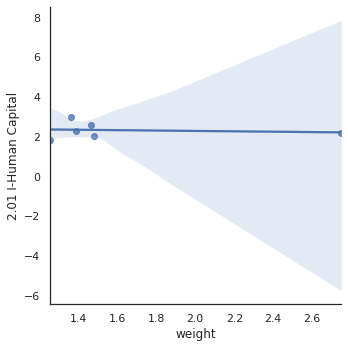

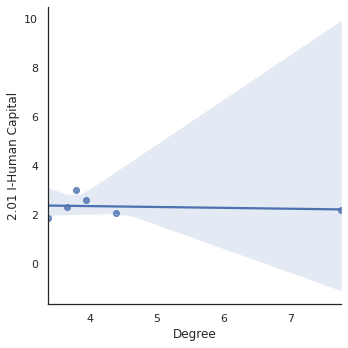

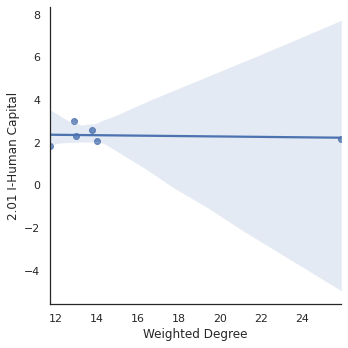

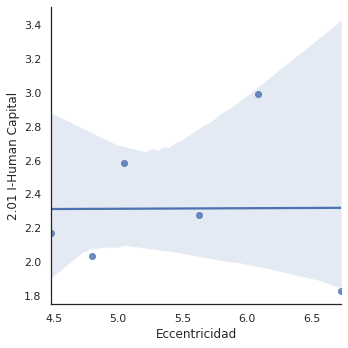

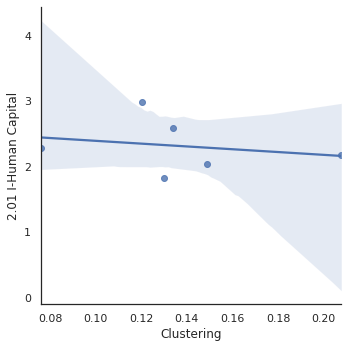

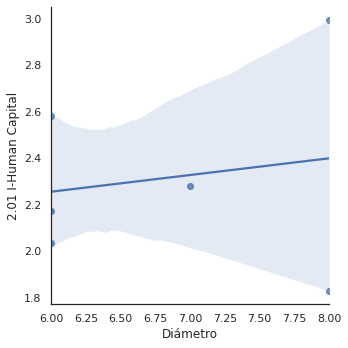

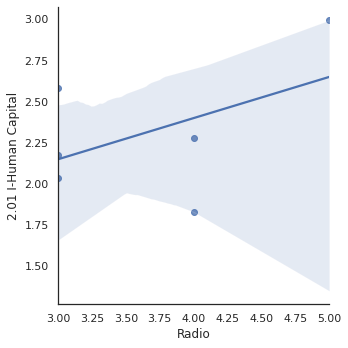

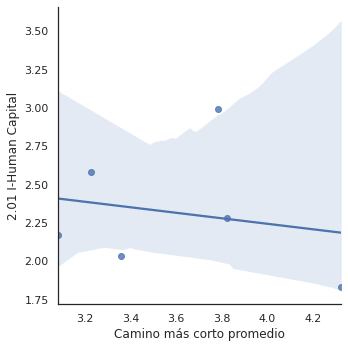

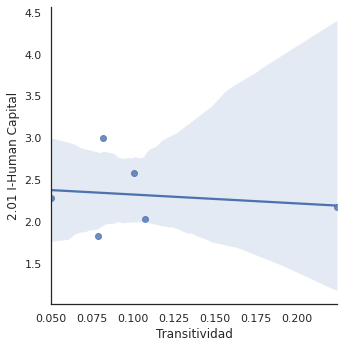

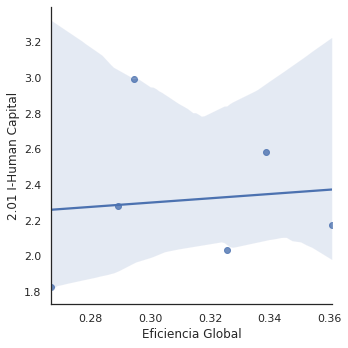

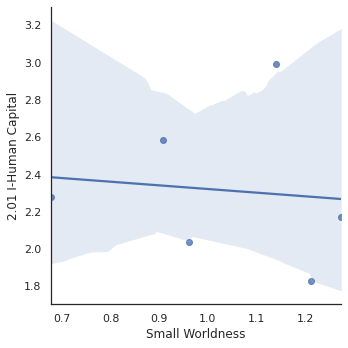

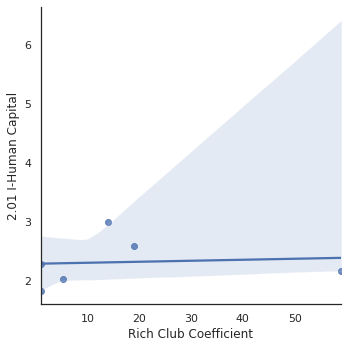

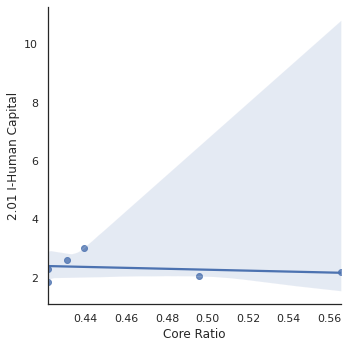

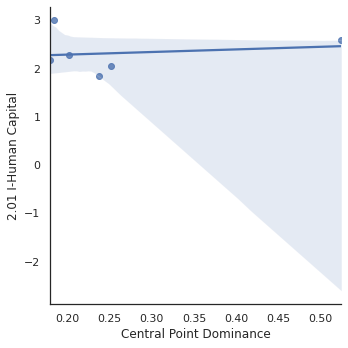

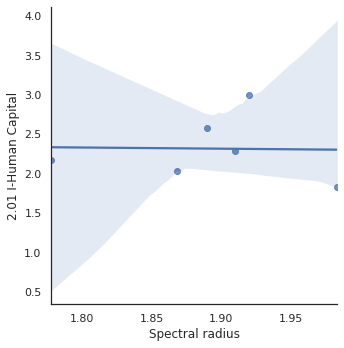

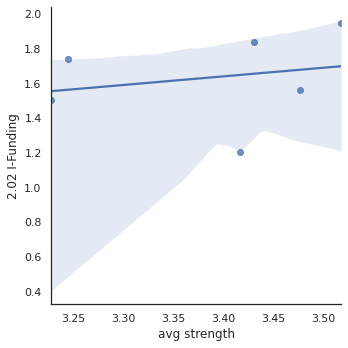

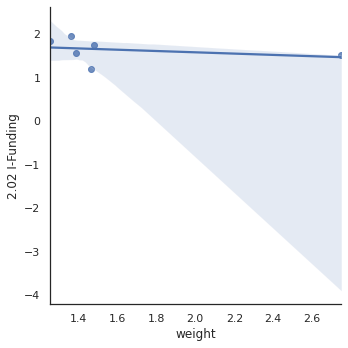

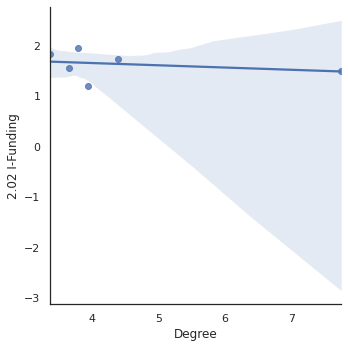

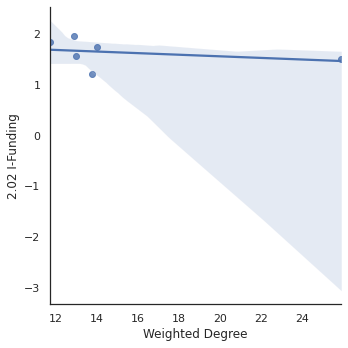

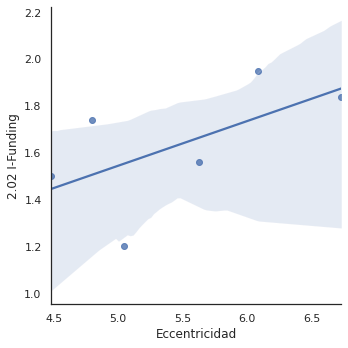

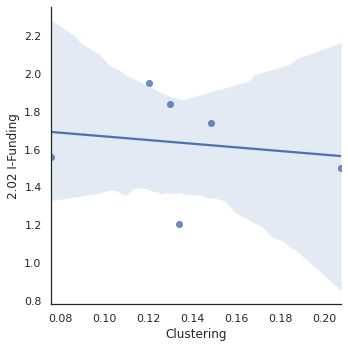

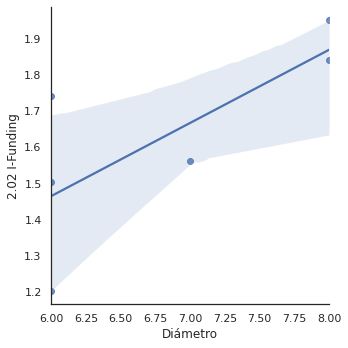

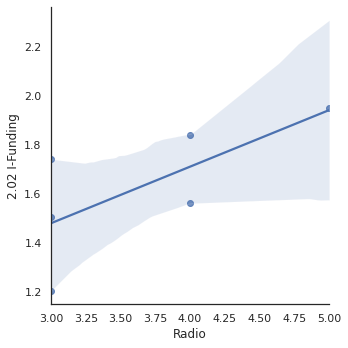

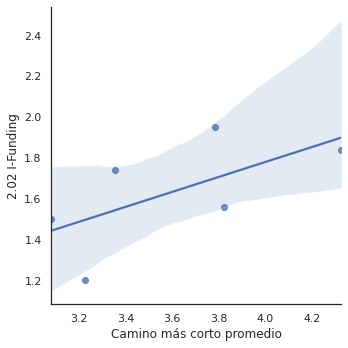

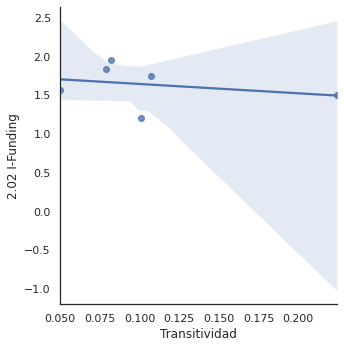

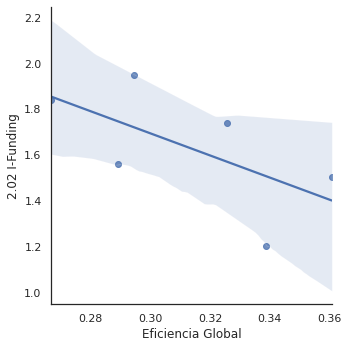

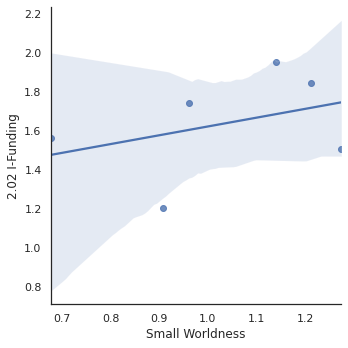

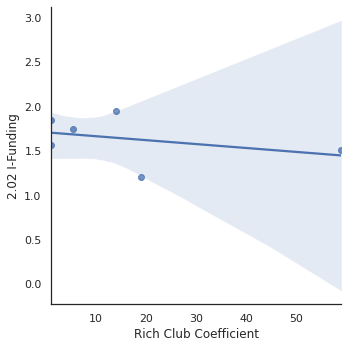

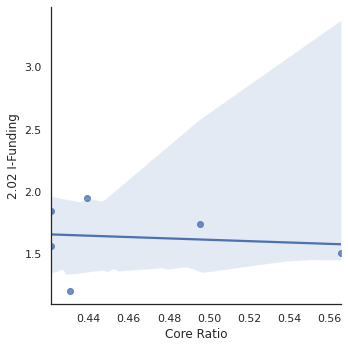

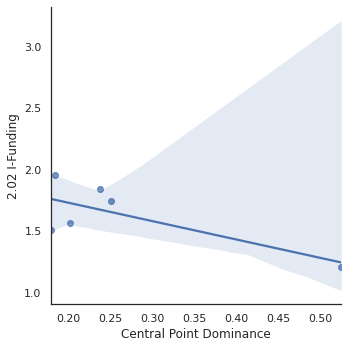

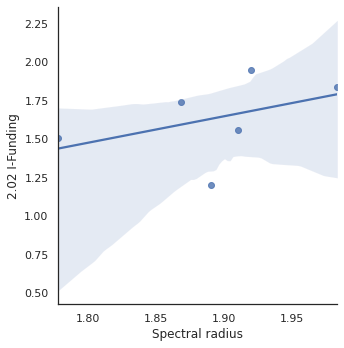

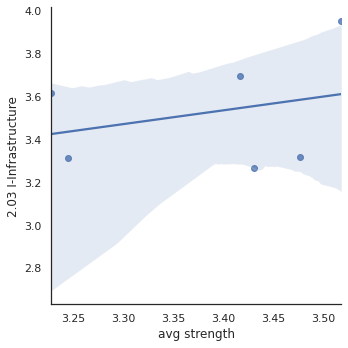

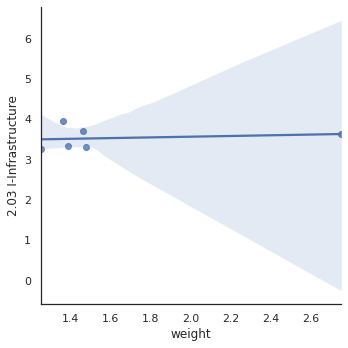

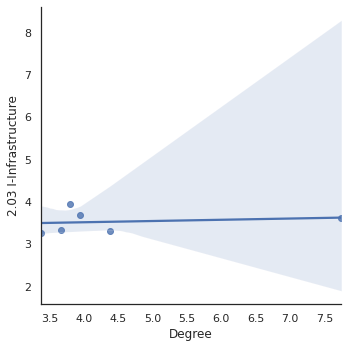

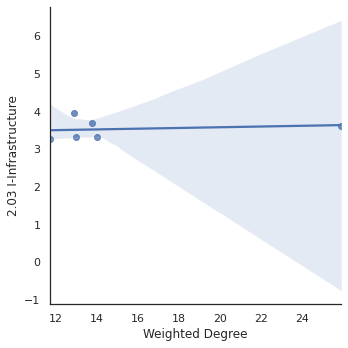

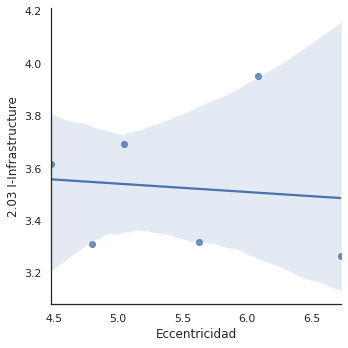

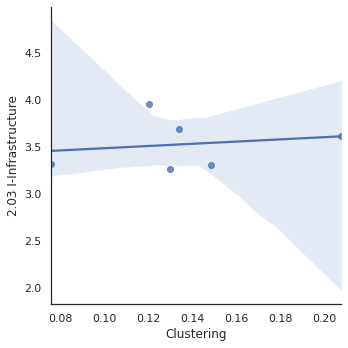

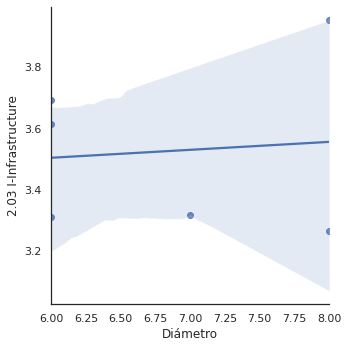

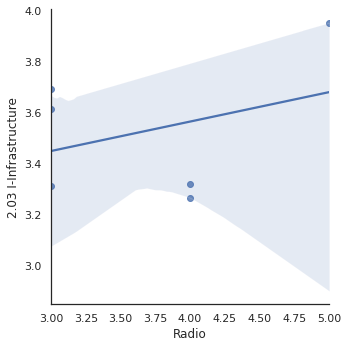

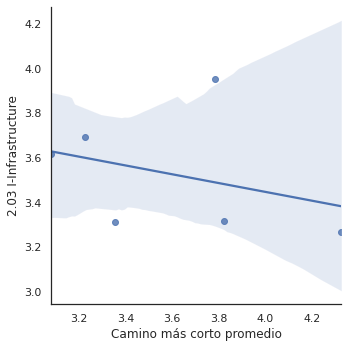

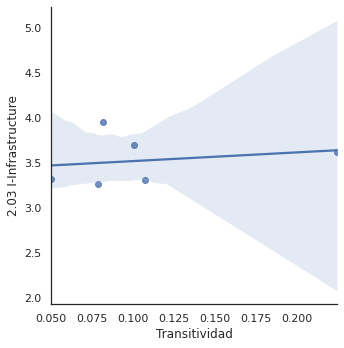

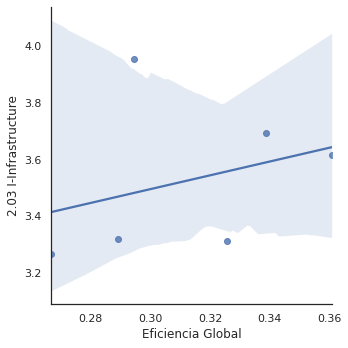

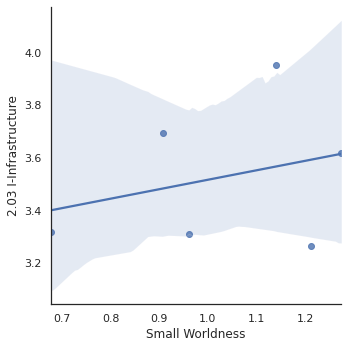

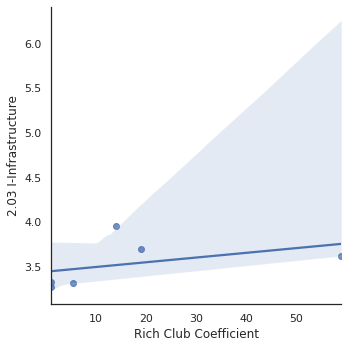

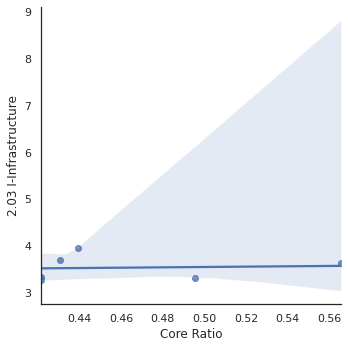

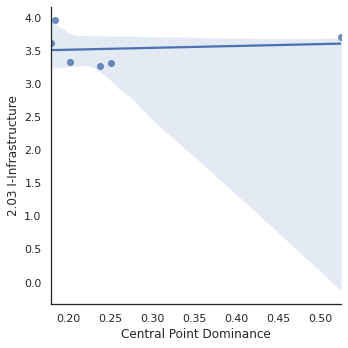

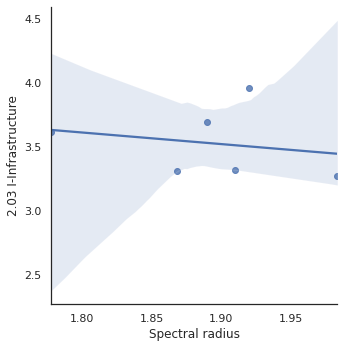

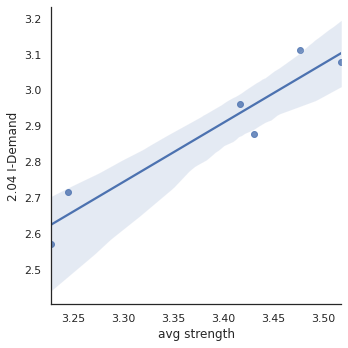

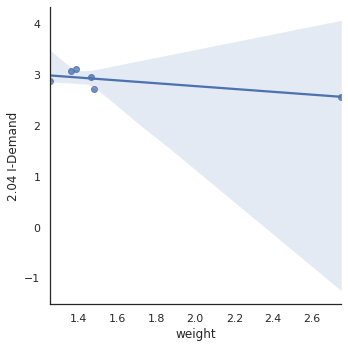

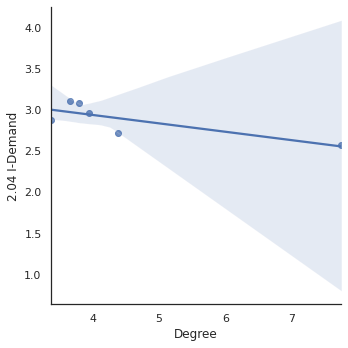

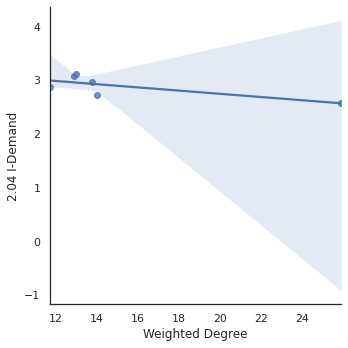

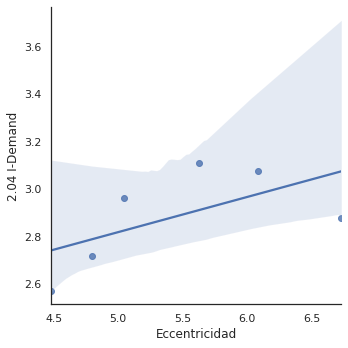

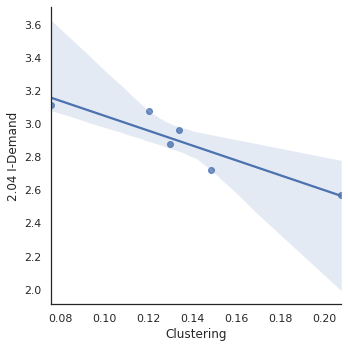

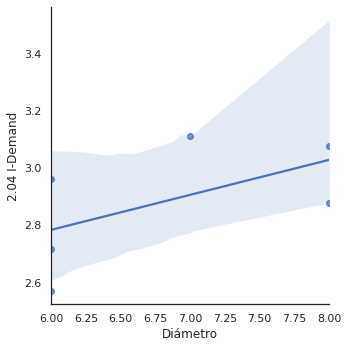

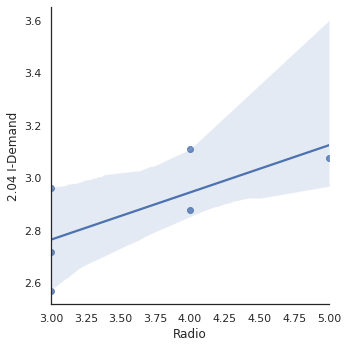

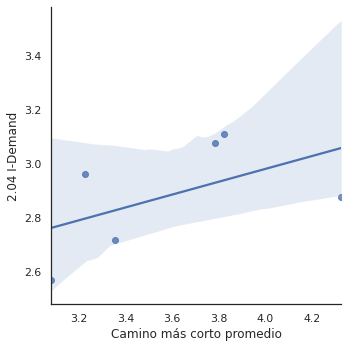

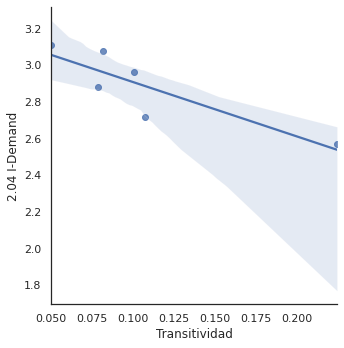

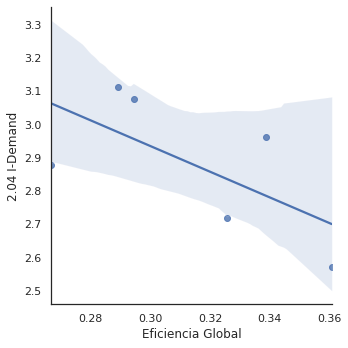

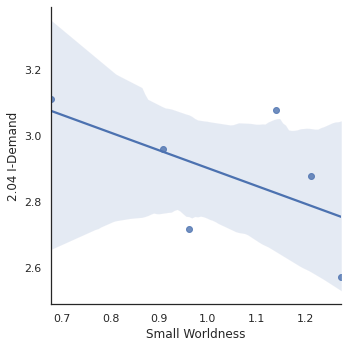

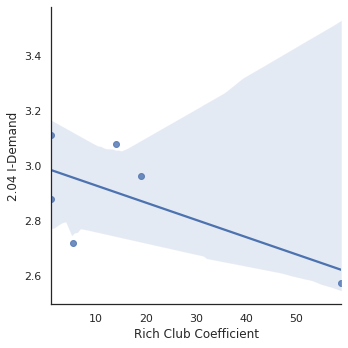

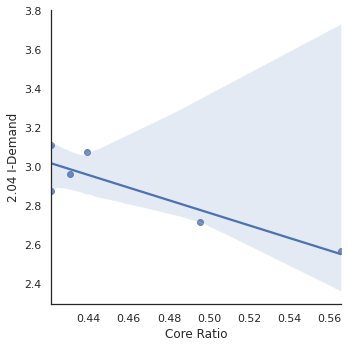

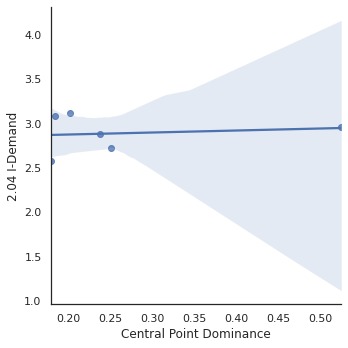

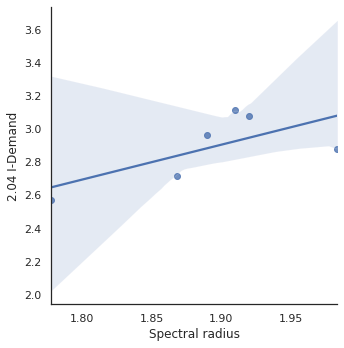

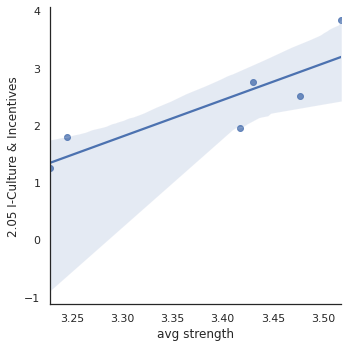

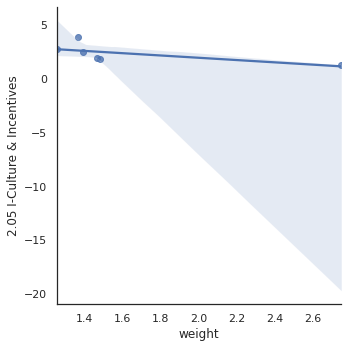

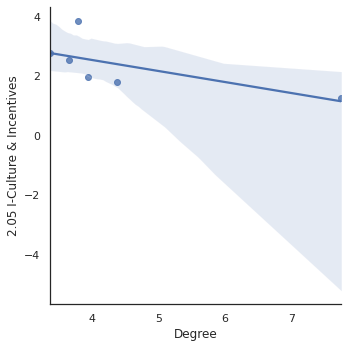

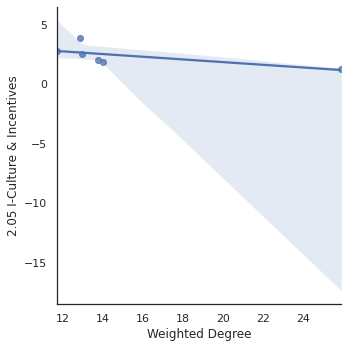

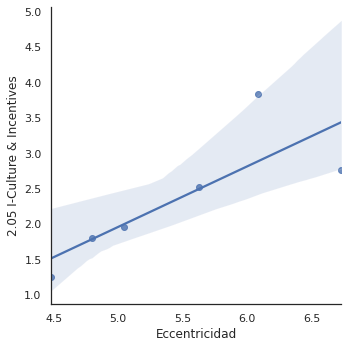

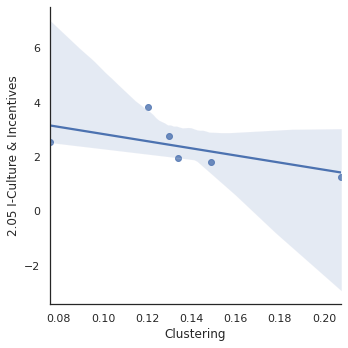

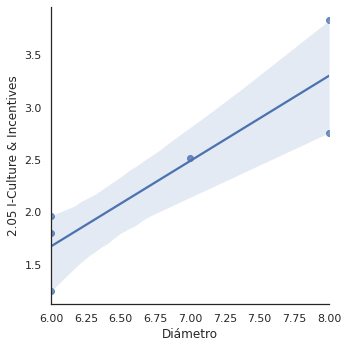

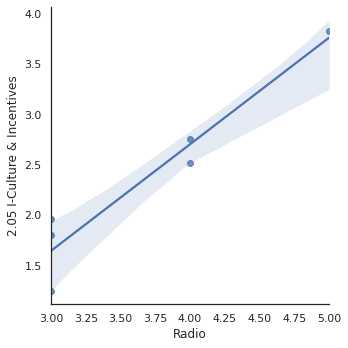

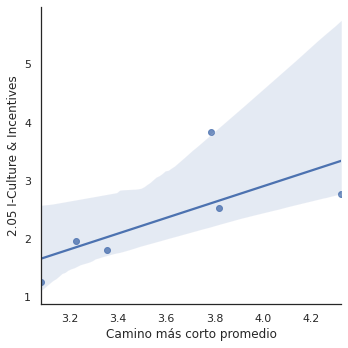

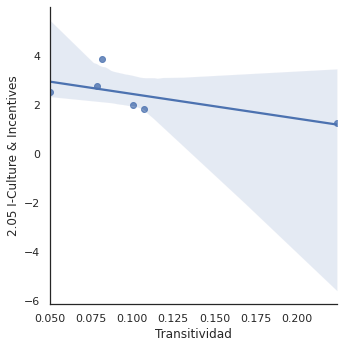

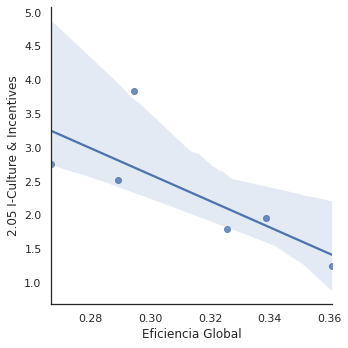

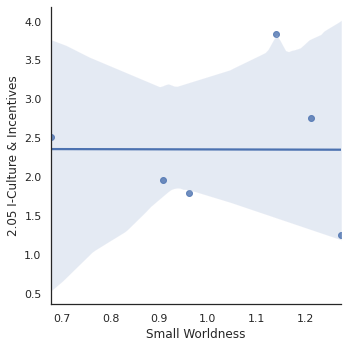

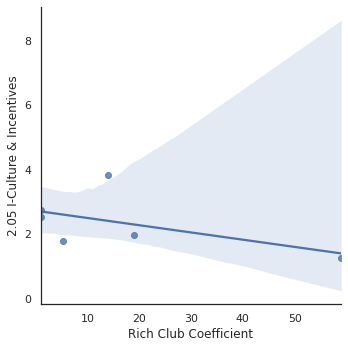

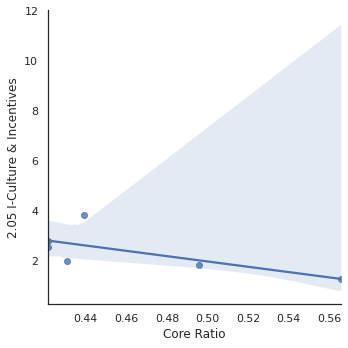

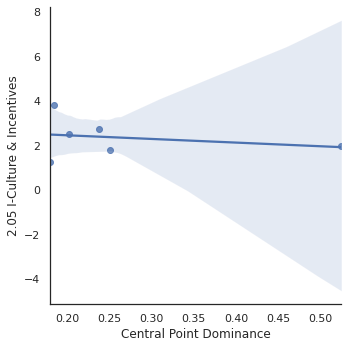

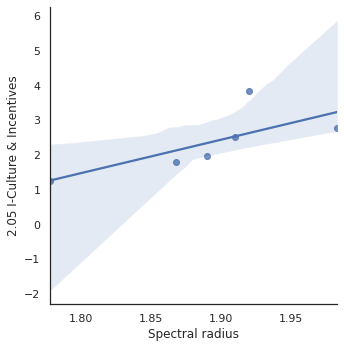

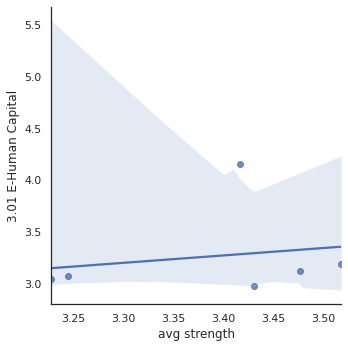

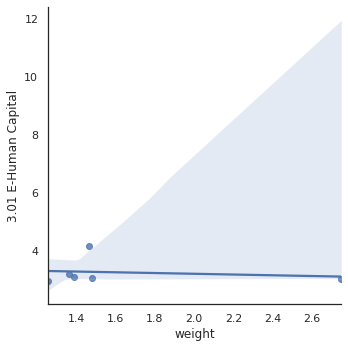

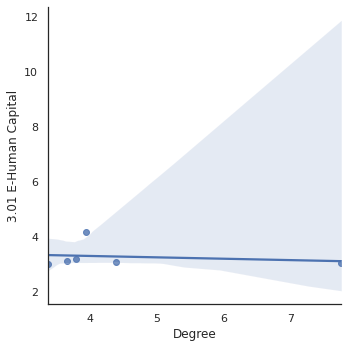

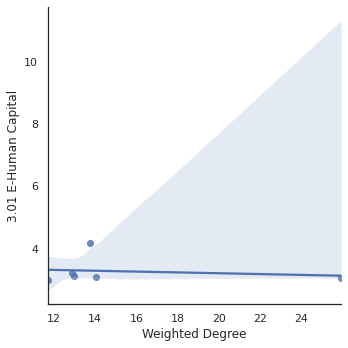

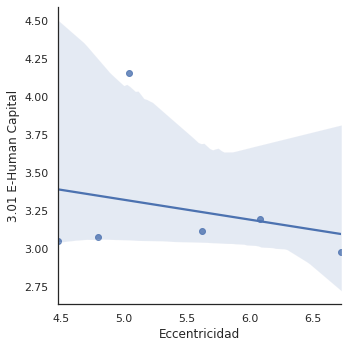

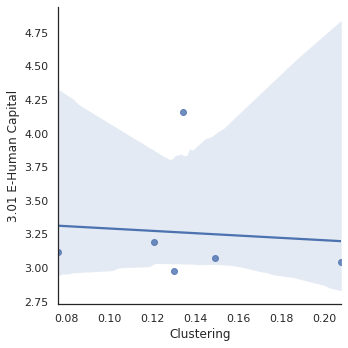

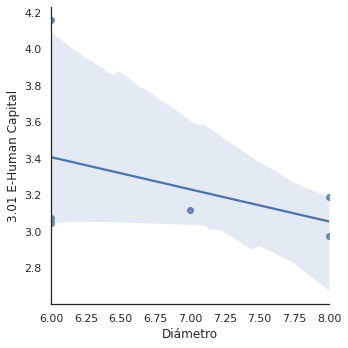

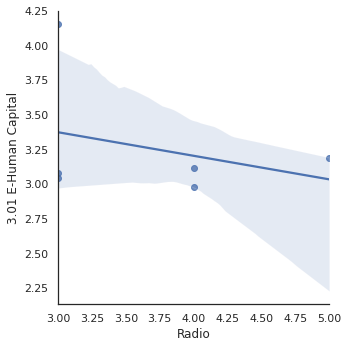

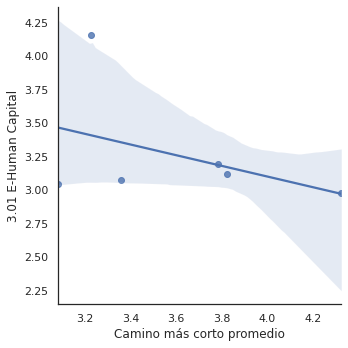

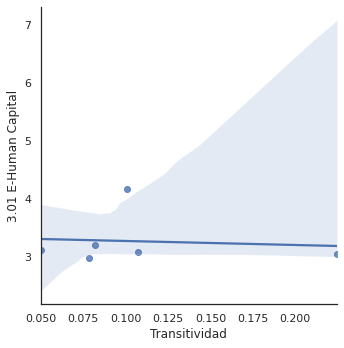

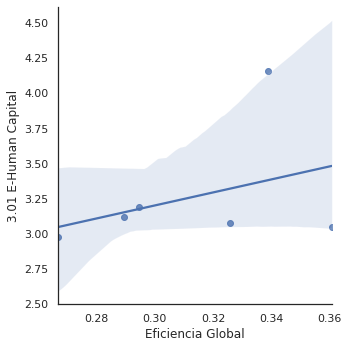

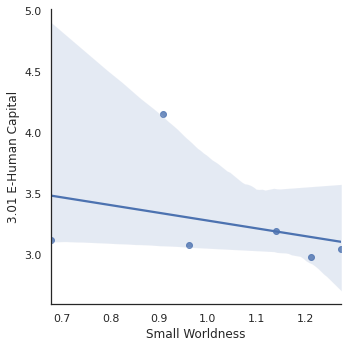

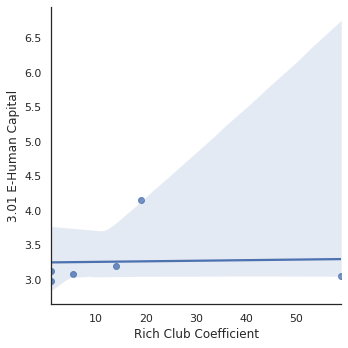

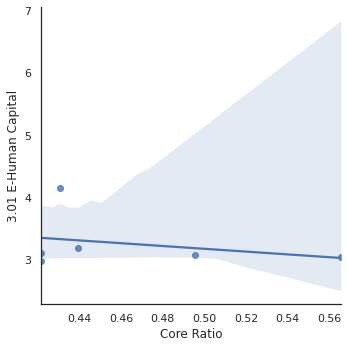

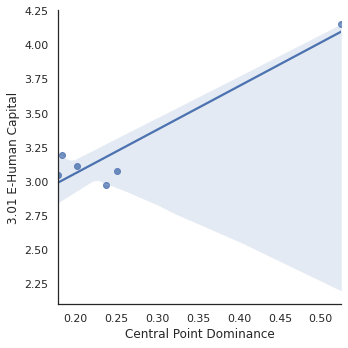

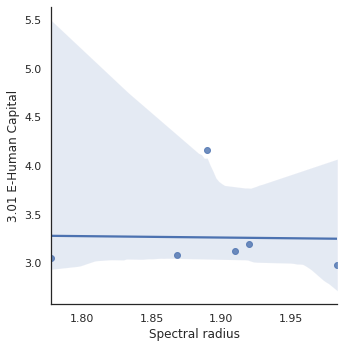

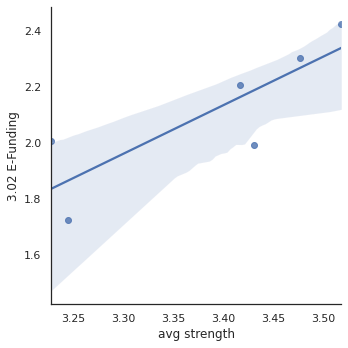

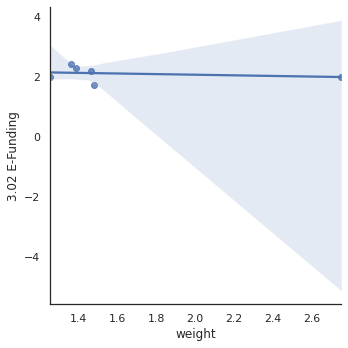

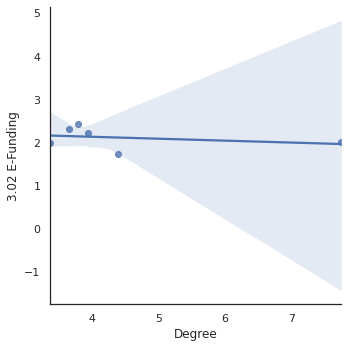

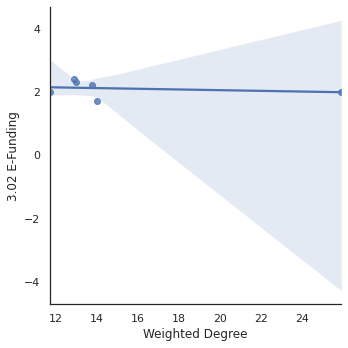

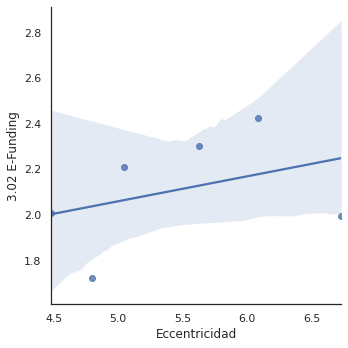

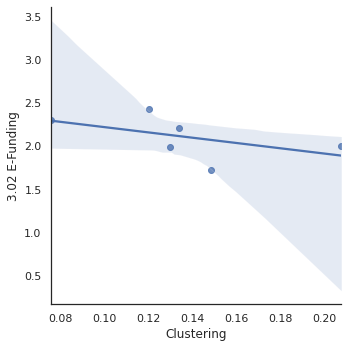

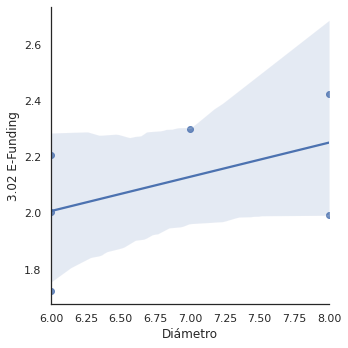

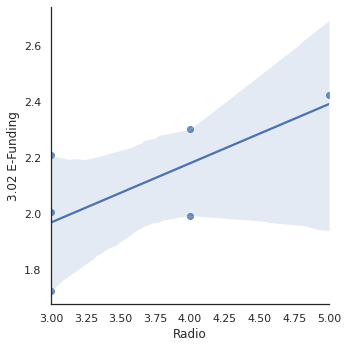

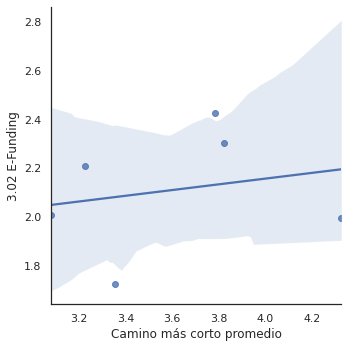

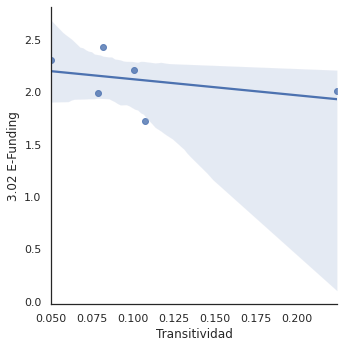

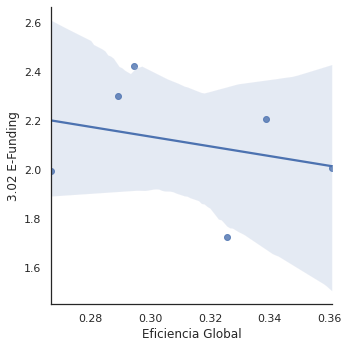

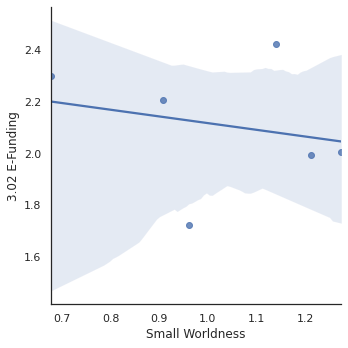

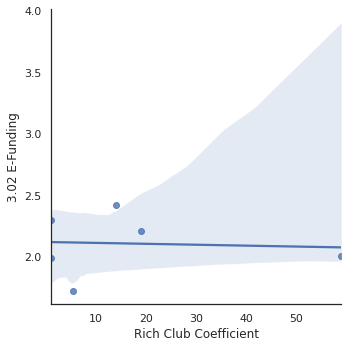

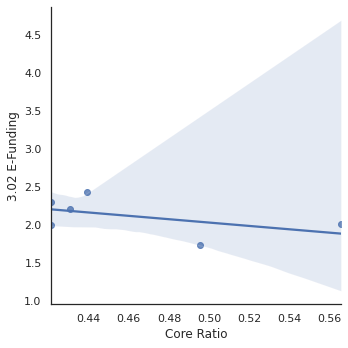

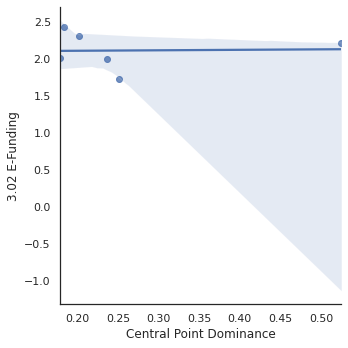

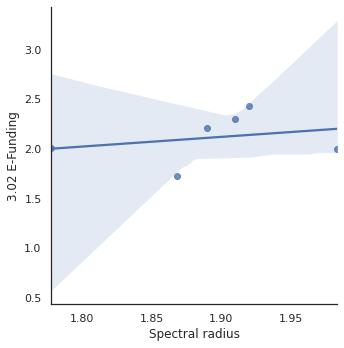

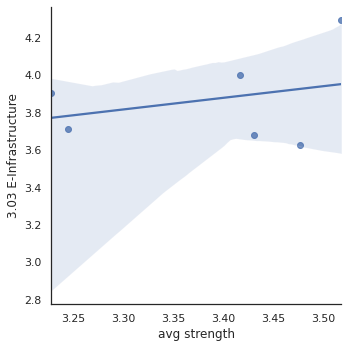

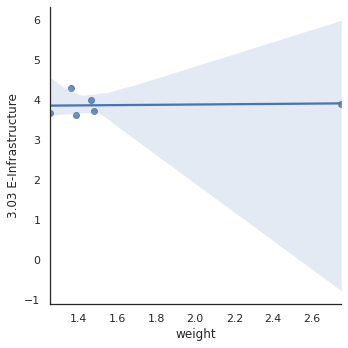

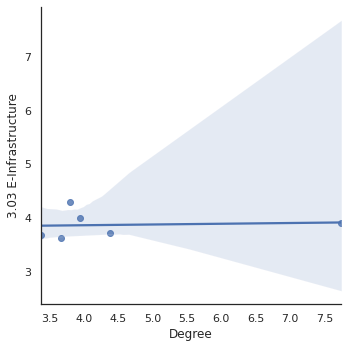

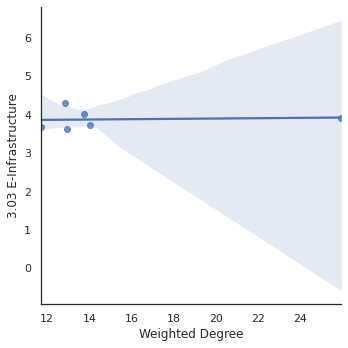

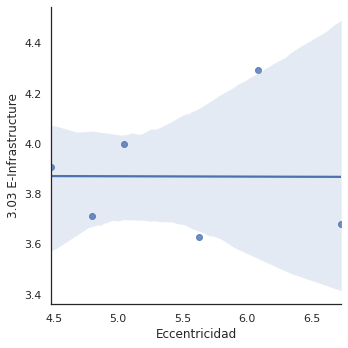

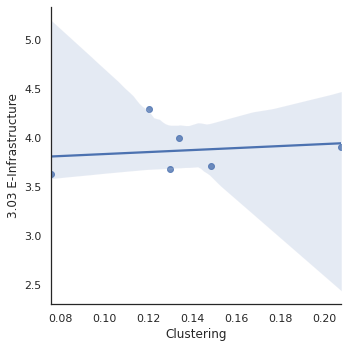

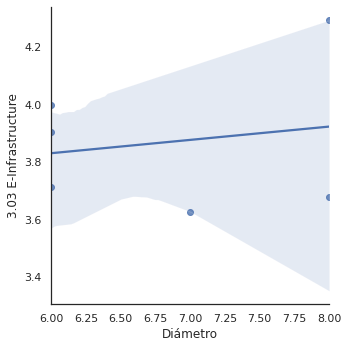

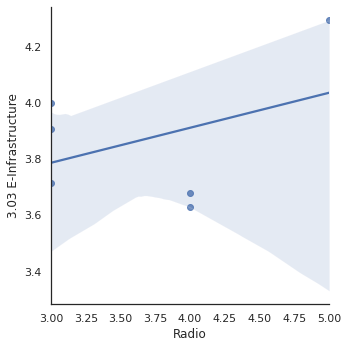

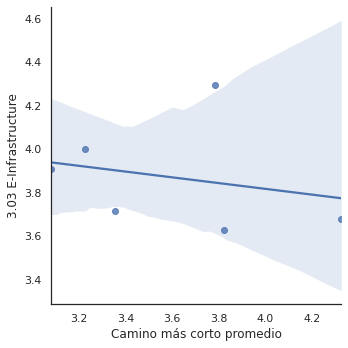

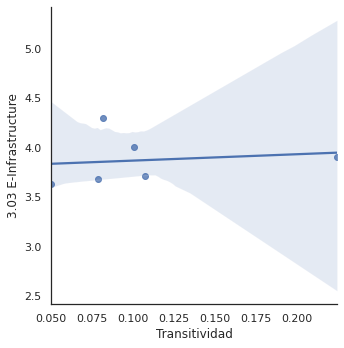

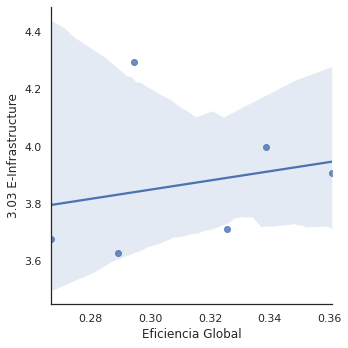

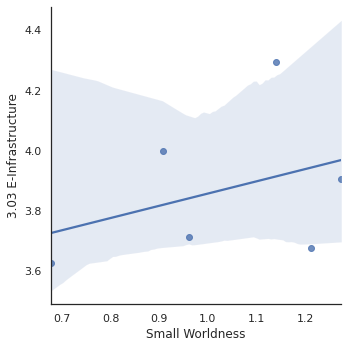

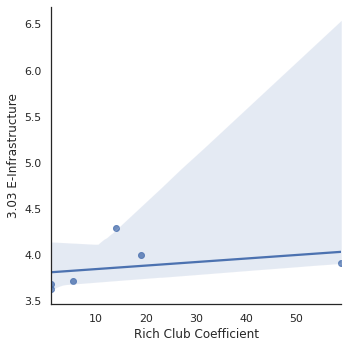

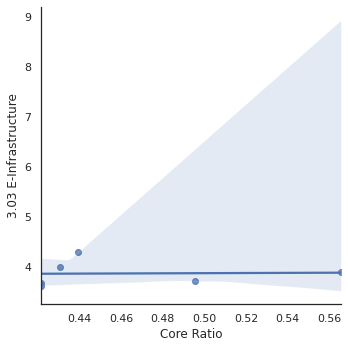

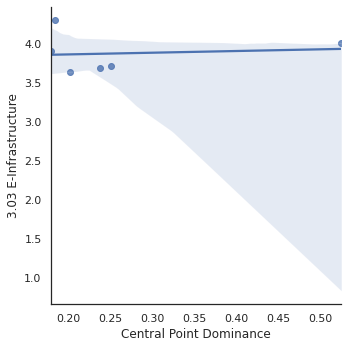

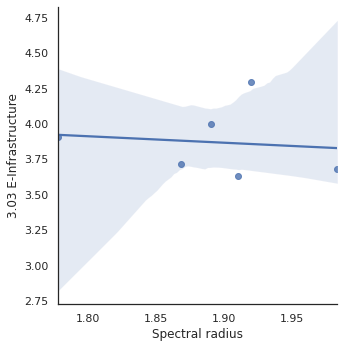

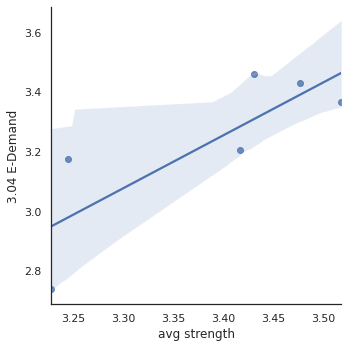

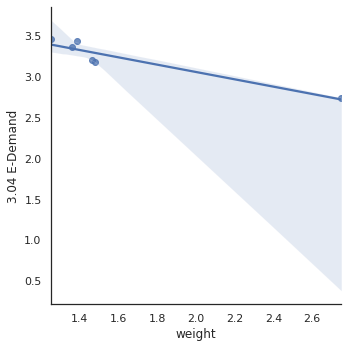

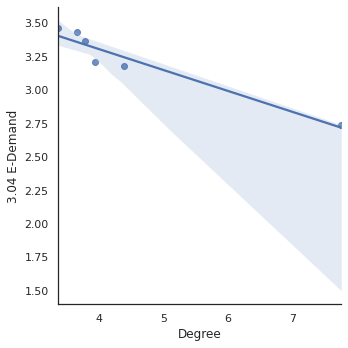

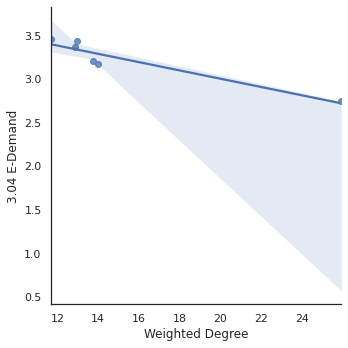

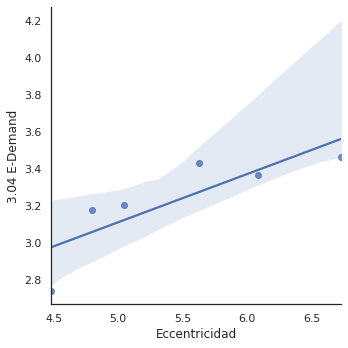

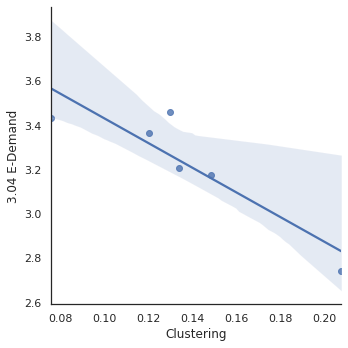

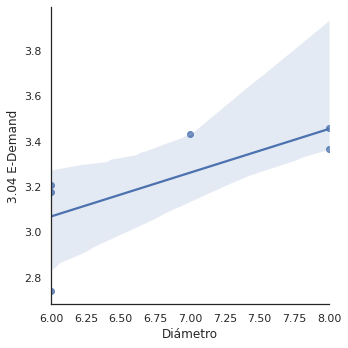

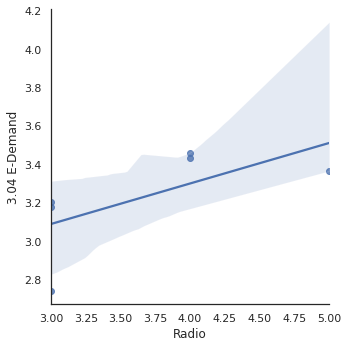

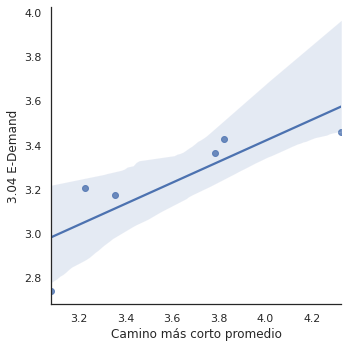

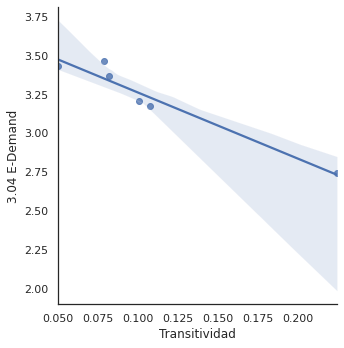

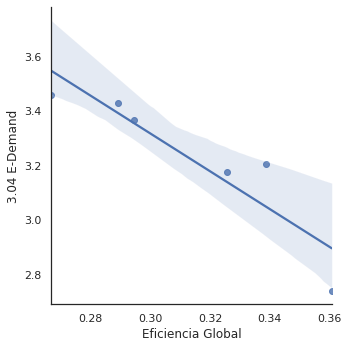

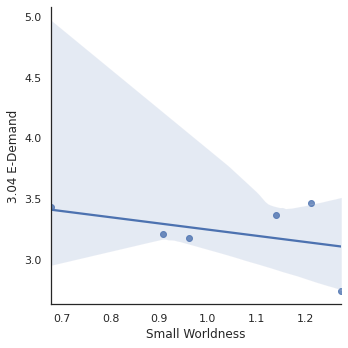

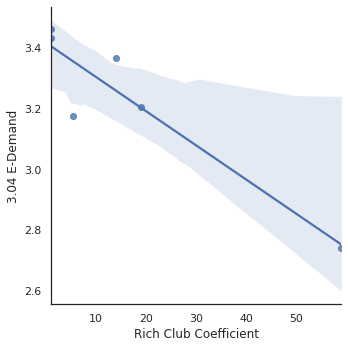

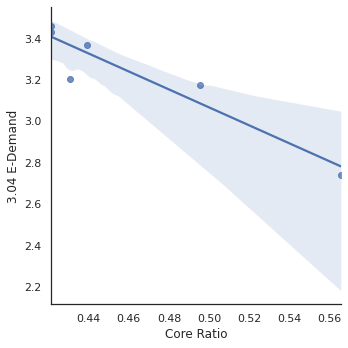

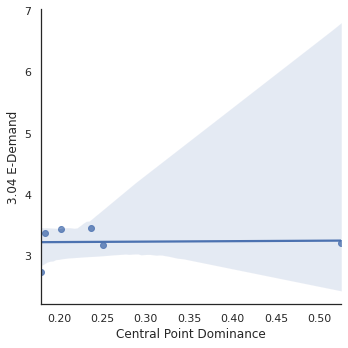

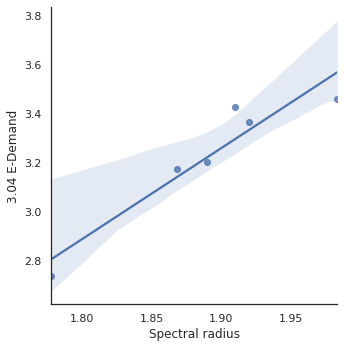

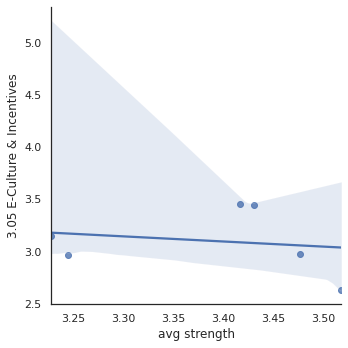

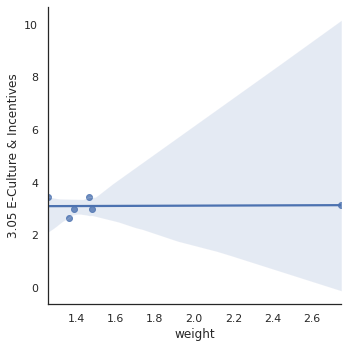

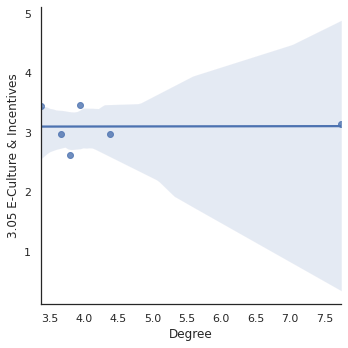

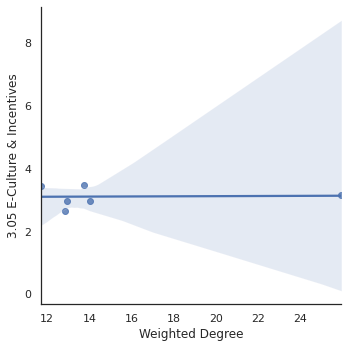

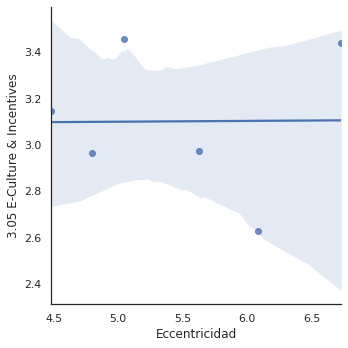

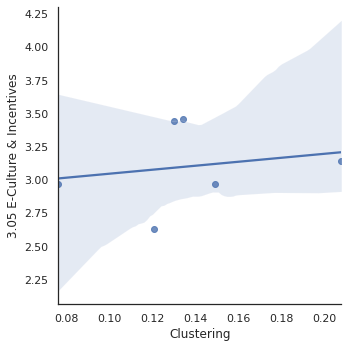

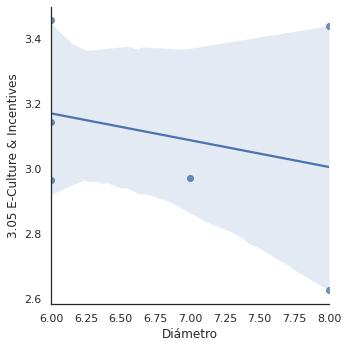

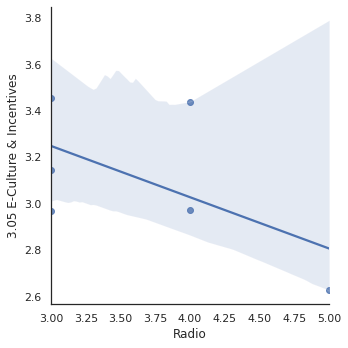

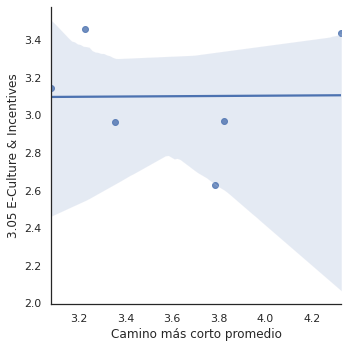

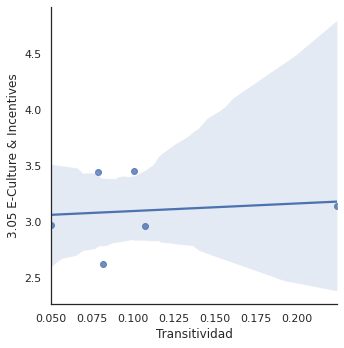

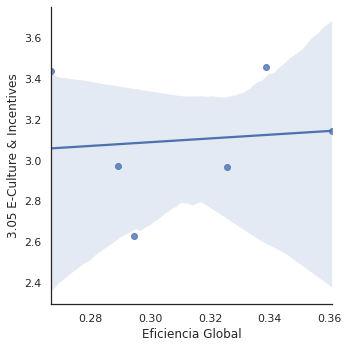

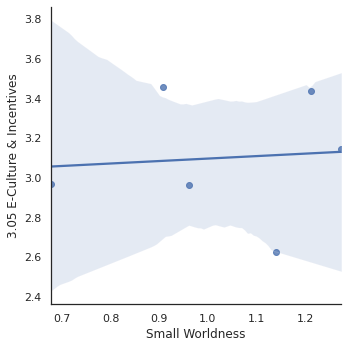

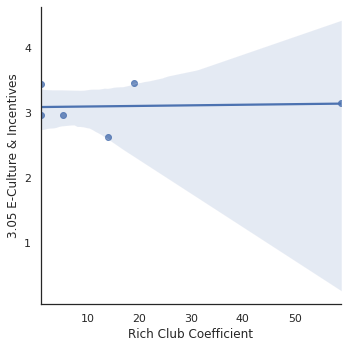

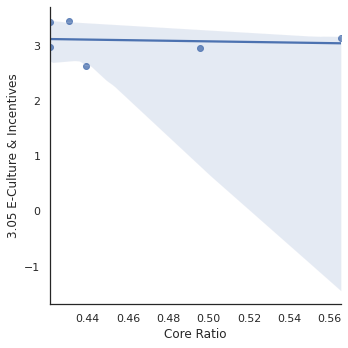

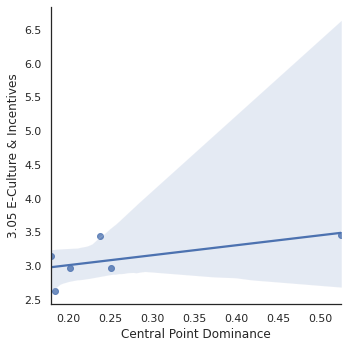

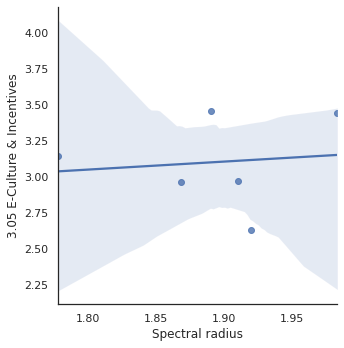

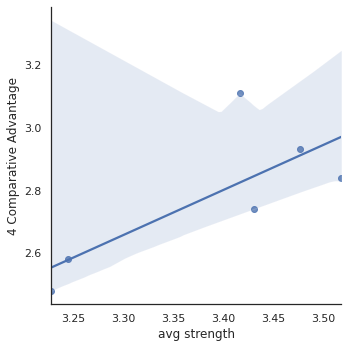

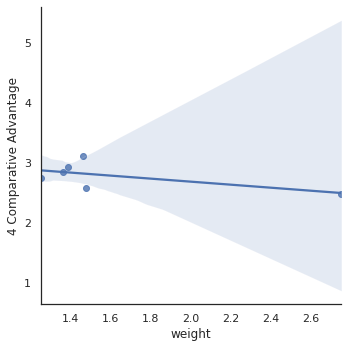

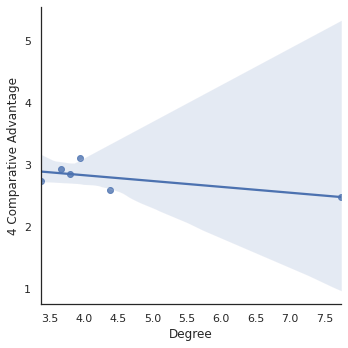

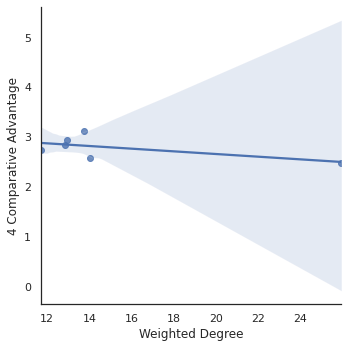

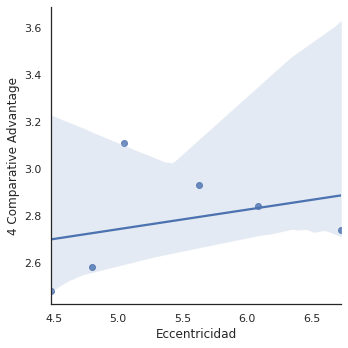

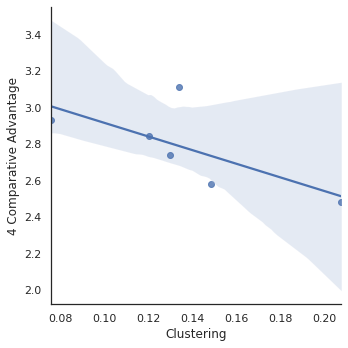

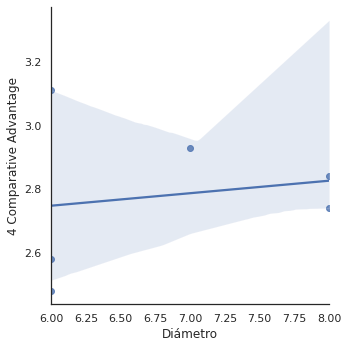

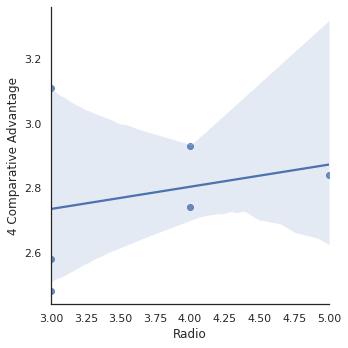

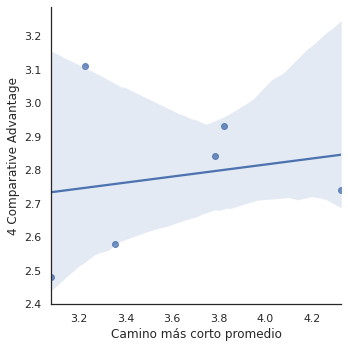

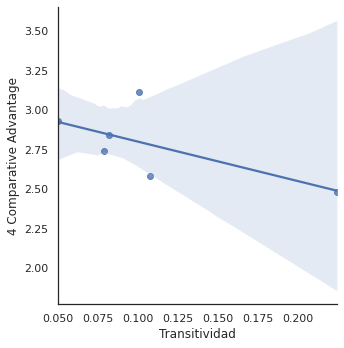

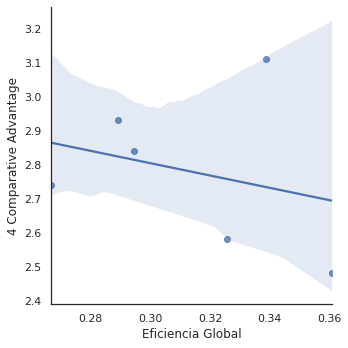

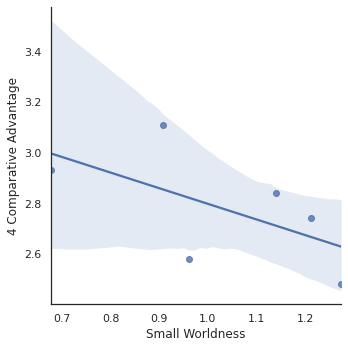

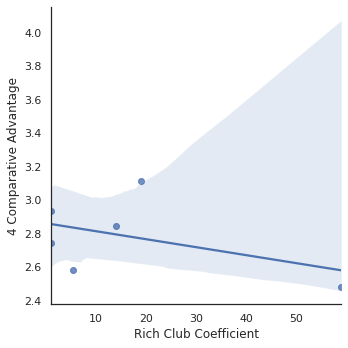

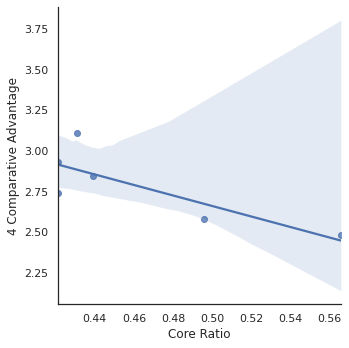

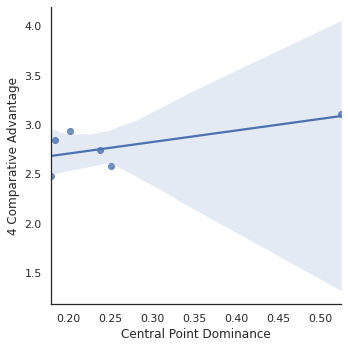

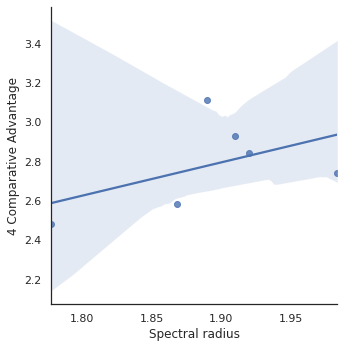

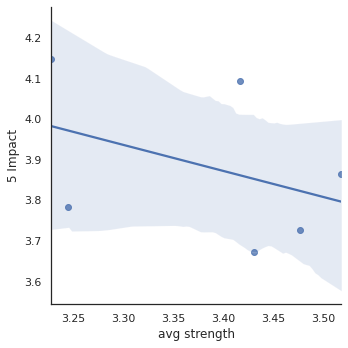

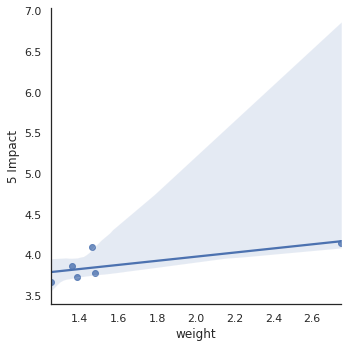

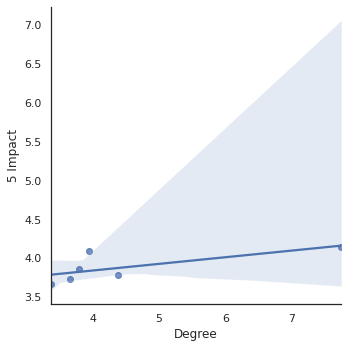

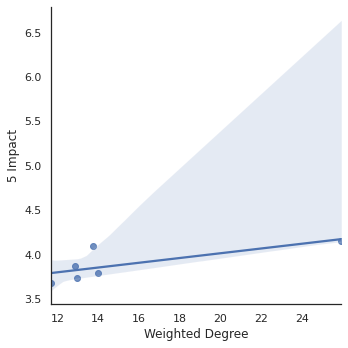

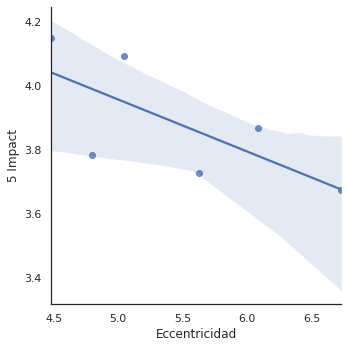

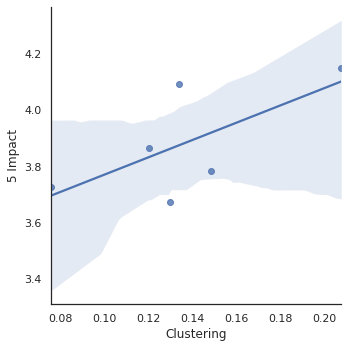

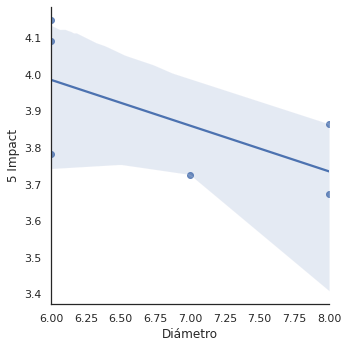

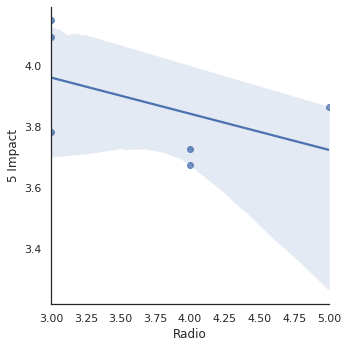

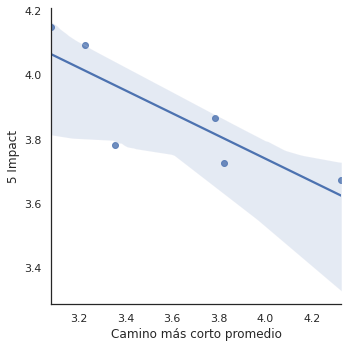

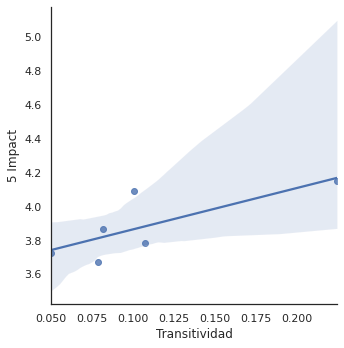

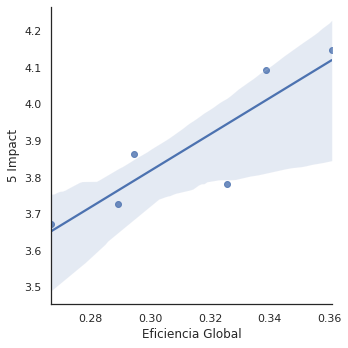

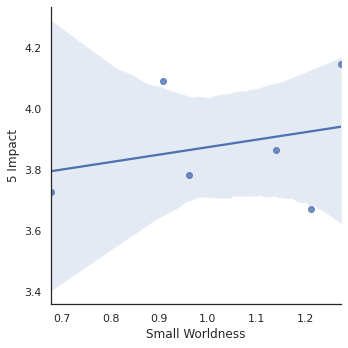

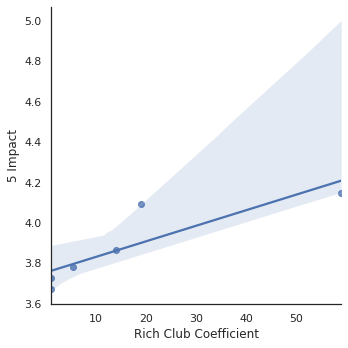

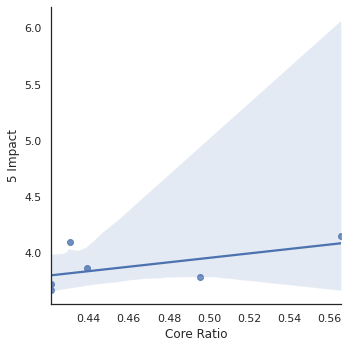

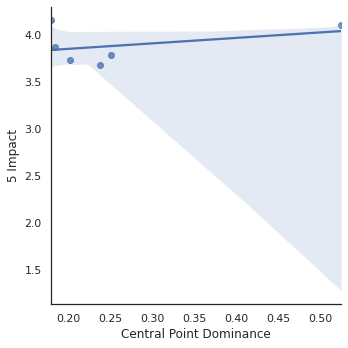

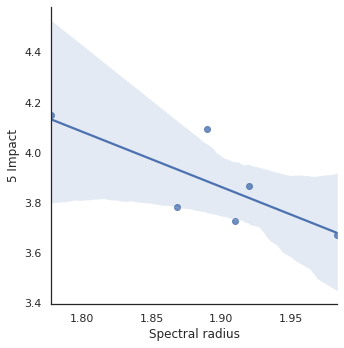

In [32]:
iecosystems_m=['1 Foundational Institutions', '2.01 I-Human Capital', '2.02 I-Funding', '2.03 I-Infrastructure', '2.04 I-Demand',
      '2.05 I-Culture & Incentives', '3.01 E-Human Capital', '3.02 E-Funding', '3.03 E-Infrastructure', '3.04 E-Demand', 
      '3.05 E-Culture & Incentives', '4 Comparative Advantage', '5 Impact']

global_m=['avg strength', 'weight', 'Degree', 'Weighted Degree', 'Eccentricidad', 'Clustering',
          'Diámetro', 'Radio', 'Camino más corto promedio', 'Transitividad', 'Eficiencia Global', 
          'Small Worldness', 'Rich Club Coefficient', 'Core Ratio', 'Central Point Dominance', 'Spectral radius']

significant_pairs=[]
for a in iecosystems_m:
  for b in global_m:
    if check_corr_significance(df_graph_ieco,a,b):
      significant_pairs.append((a,b))

significant_pairs
